In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [211]:
visitation = pd.read_csv('Visitation Data.csv')
climate = pd.read_csv('Weather Data.csv')

In [212]:
visitation.head()

Year  Week  Mt. Baw Baw  Mt. Stirling  Mt. Hotham  Falls Creek  \
0  2014.0   1.0        555.0          60.0      3483.0       2790.0   
1  2014.0   2.0        804.0          42.0      1253.0       1425.0   
2  2014.0   3.0        993.0          30.0      2992.0       2101.0   
3  2014.0   4.0       2976.0         165.0      9680.0       9544.0   
4  2014.0   5.0      11112.0         645.0     29628.0      26211.0   

   Mt. Buller  Selwyn  Thredbo  Perisher  Charlotte Pass  
0      8296.0  1041.0   5535.0    7370.0           408.0  
1      1987.0   383.0   2090.0    2751.0           151.0  
2      2413.0   597.0   3216.0    4255.0           230.0  
3     18831.0  2877.0  15497.0   20265.0          1134.0  
4     49217.0  8588.0  46546.0   61339.0          3403.0

In [213]:
visitation = visitation.iloc[:165,:]
visitation.describe()

Year        Week   Mt. Baw Baw  Mt. Stirling    Mt. Hotham  \
count   165.000000  165.000000    165.000000    165.000000    165.000000   
mean   2019.000000    8.000000   5373.648485    589.981818  20110.333333   
std       3.171904    4.333646   3924.269031    529.497558  12198.935589   
min    2014.000000    1.000000      0.000000      0.000000      0.000000   
25%    2016.000000    4.000000   1757.000000     98.000000   8368.000000   
50%    2019.000000    8.000000   5565.000000    480.000000  21856.000000   
75%    2022.000000   12.000000   8513.000000    962.000000  30944.000000   
max    2024.000000   15.000000  18031.000000   2097.000000  44648.000000   

        Falls Creek    Mt. Buller        Selwyn       Thredbo      Perisher  \
count    165.000000    165.000000    165.000000    165.000000    165.000000   
mean   24027.145455  29349.296970   5536.533333  30020.884848  39649.515152   
std    14176.688461  17768.711945   3383.338655  18363.819945  24258.783674   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%     8741.000000  12397.000000   2180.000000  11543.000000  15236.000000   
50%    28099.000000  33328.000000   6454.000000  34676.000000  46265.000000   
75%    36692.000000  44315.000000   8530.000000  46015.000000  60788.000000   
max    49697.000000  66326.000000  12863.000000  70634.000000  93226.000000   

       Charlotte Pass  
count      165.000000  
mean      2181.812121  
std       1334.790842  
min          0.000000  
25%        842.000000  
50%       2542.000000  
75%       3344.000000  
max       5033.000000

In [214]:
weather.isna().sum()

Bureau of Meteorology station number       0
Year                                       0
Month                                      0
Day                                        0
Maximum temperature (Degree C)          1538
Minimum temperature (Degree C)          1533
Rainfall amount (millimetres)           1956
dtype: int64

# EDA

<Axes: ylabel='Count'>

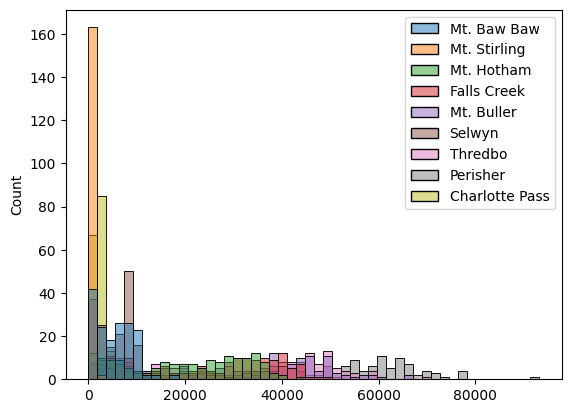

In [216]:
sns.histplot(snow_locations, bins = 50)

In [217]:
visitation['Year'].unique()

array([2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021., 2022.,
       2023., 2024.])

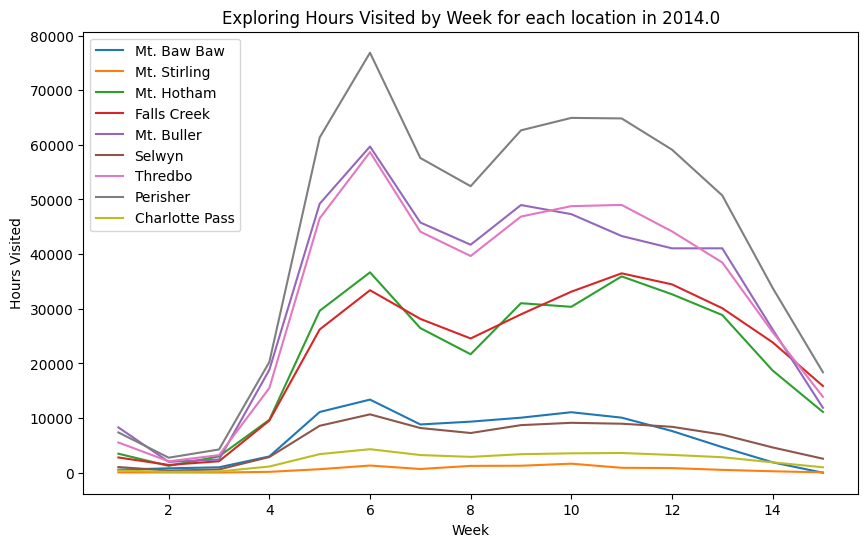

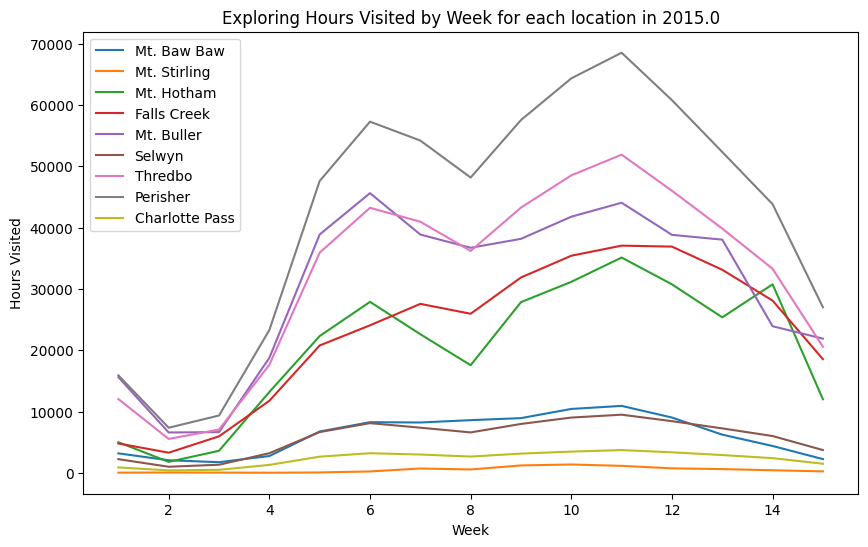

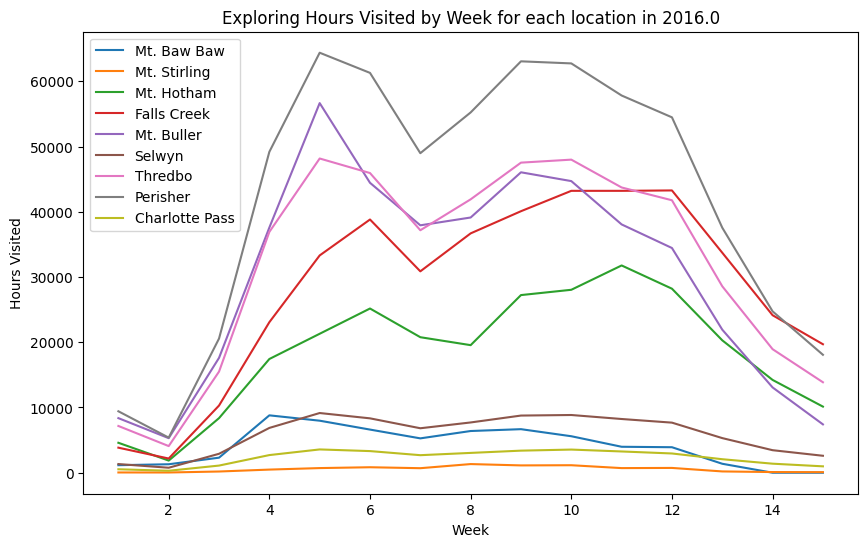

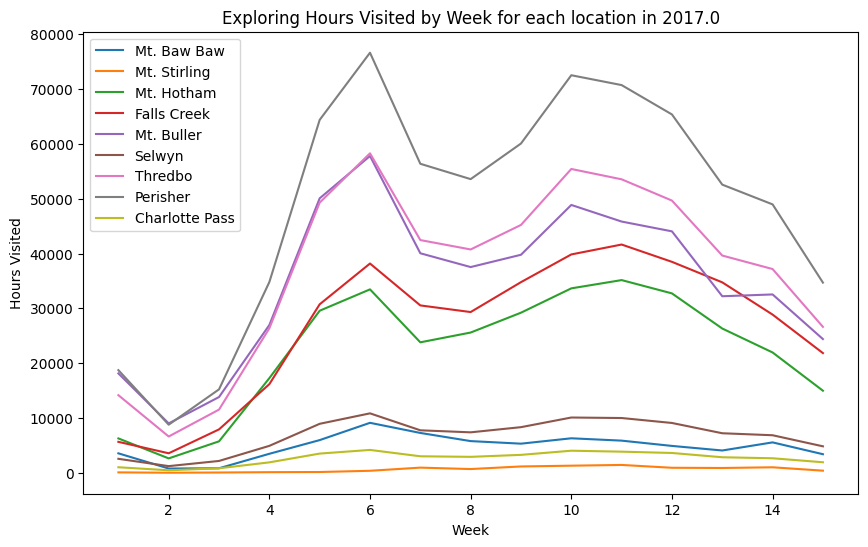

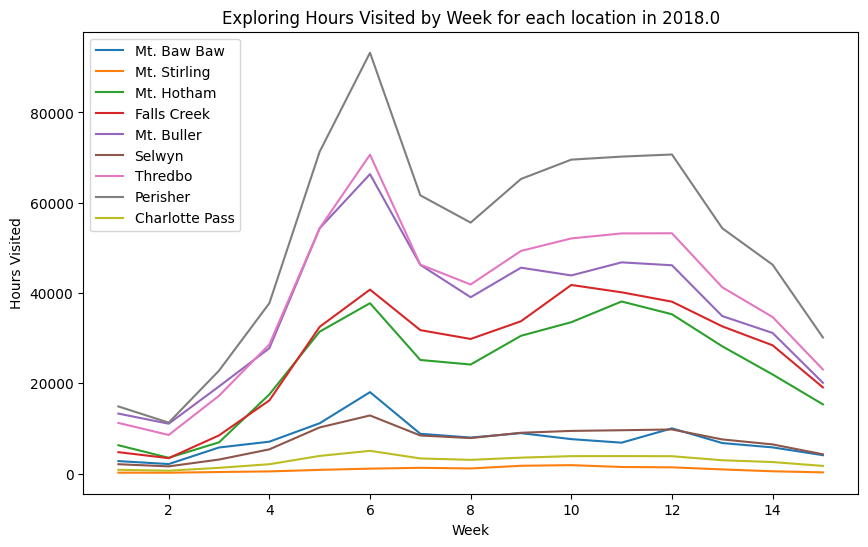

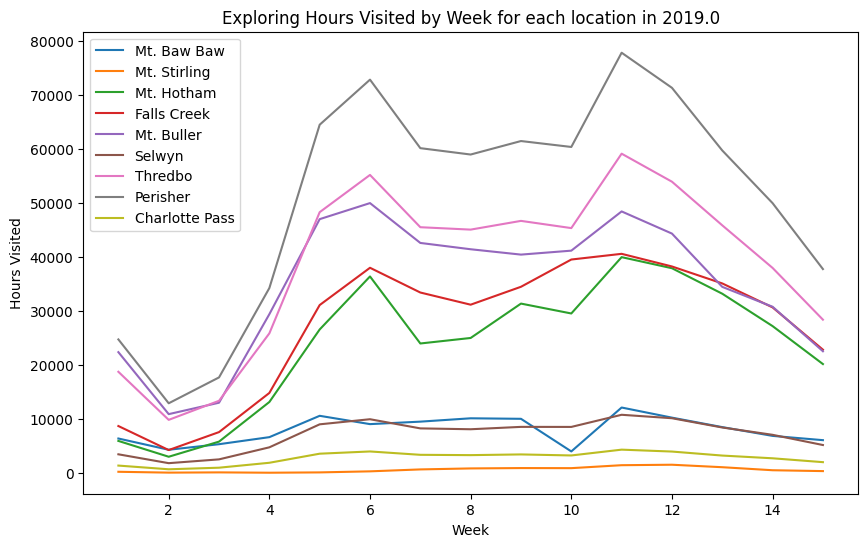

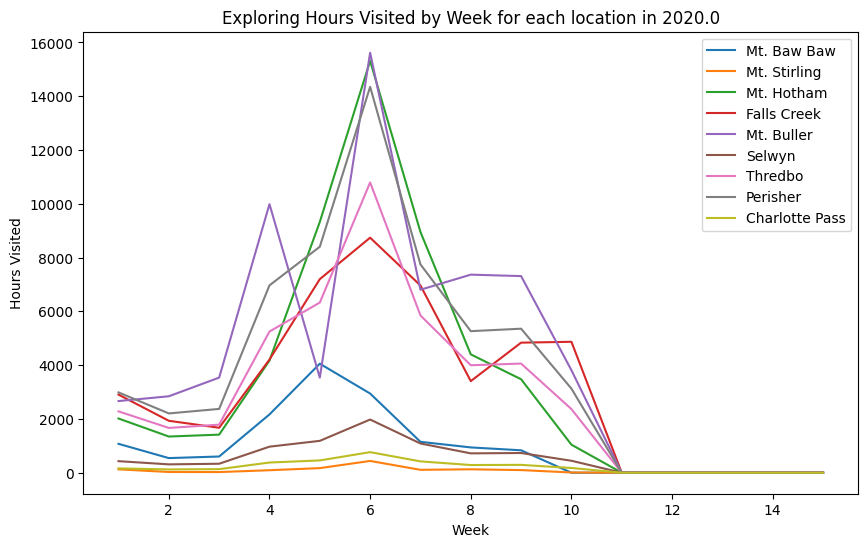

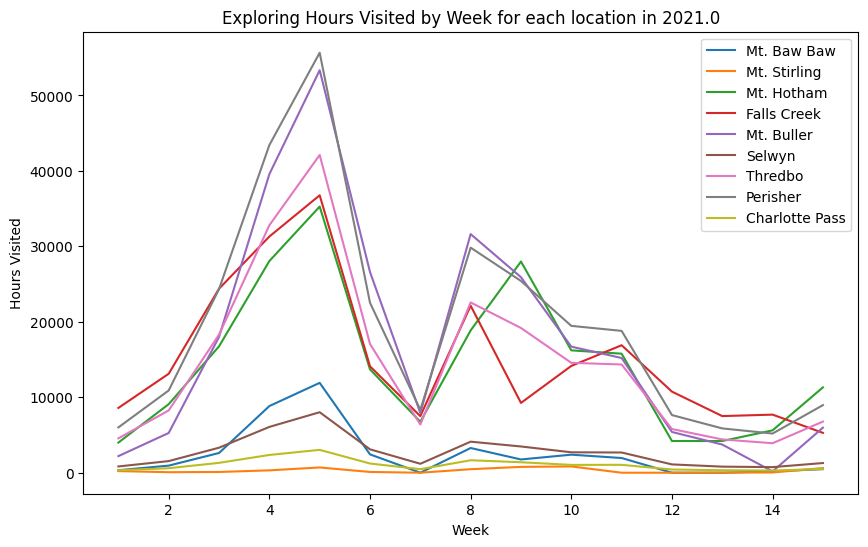

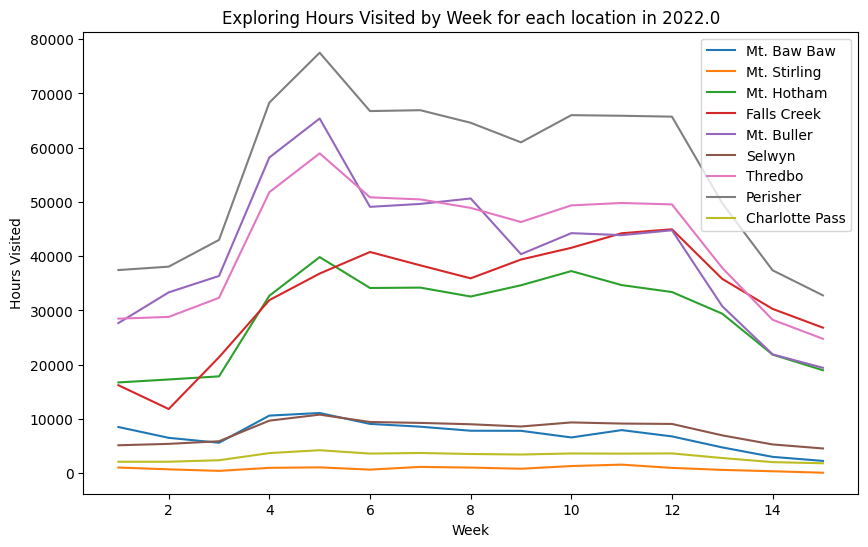

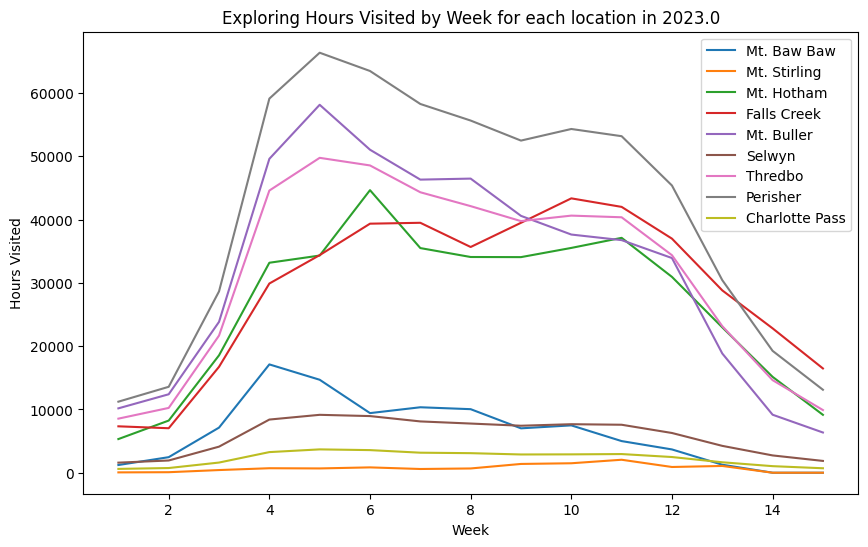

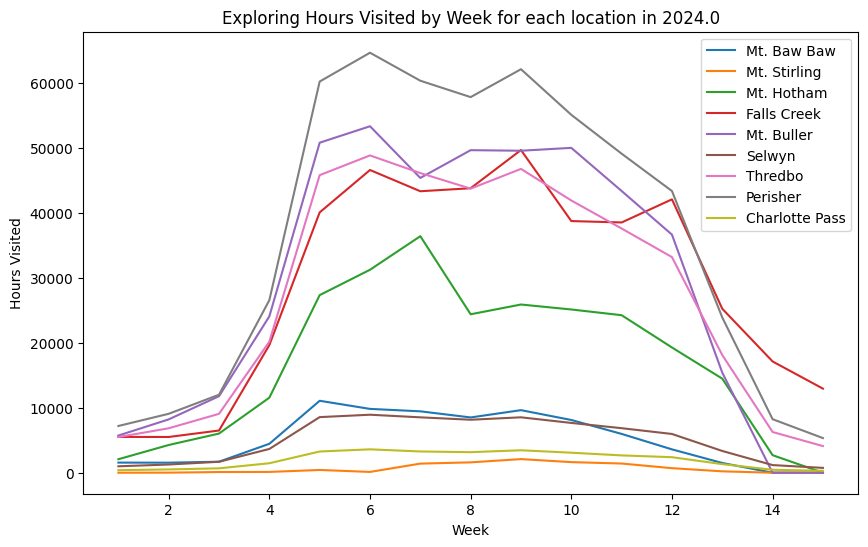

In [218]:
years = visitation['Year'].unique()

locations = [col for col in visitation.columns if col not in ['Year', 'Week']]

for year in sorted(years):
    visitation_year = visitation[visitation['Year'] == year]
    
    plt.figure(figsize=(10,6))
    for loc in locations:
        plt.plot(visitation_year['Week'], visitation_year[loc], label=loc)
    
    plt.xlabel("Week")
    plt.ylabel("Hours Visited")
    plt.title(f"Exploring Hours Visited by Week for each location in {year}")
    plt.legend()
    plt.show()

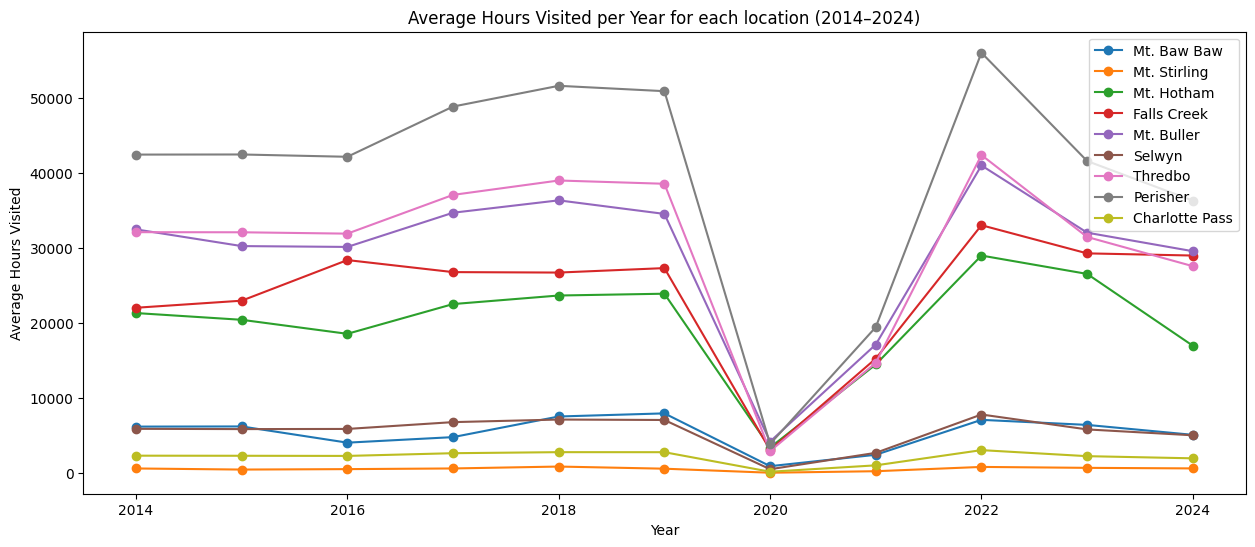

In [219]:
visitation_yearly = visitation.groupby("Year")[locations].mean()

plt.figure(figsize=(15,6))
for loc in locations:
    plt.plot(visitation_yearly.index, visitation_yearly[loc], marker='o', label=loc)

plt.xlabel("Year")
plt.ylabel("Average Hours Visited")
plt.title("Average Hours Visited per Year for each location (2014–2024)")
plt.legend()
plt.show()

In [127]:
def assign_ski_week(row):
    year = row.date.year
    #Week 1 start
    start = pd.Timestamp(year, 6, 9) 
    #Week 15 end
    end   = pd.Timestamp(year, 9, 21)  

    if not (start <= row.date <= end):
        return np.nan
    
    #Days since 9 June
    days_offset = (row.date - start).days
    #Weeks since 9 June
    week = days_offset // 7 + 1
    return week

def createDataframe(resort_name, station_number):
    #Create visitation dataframe for just the specific skiing resort
    specific_visitation = visitation[["Year", "Week", resort_name]].rename(
        columns={resort_name: "visitation"}
    )
    
    #Create climate dataframe for just the specific station number
    specific_climate = climate[climate["Bureau of Meteorology station number"] == station_number].copy()
    
    #Build datetime column
    specific_climate["date"] = pd.to_datetime(specific_climate[["Year", "Month", "Day"]])
    
    #Apply the assign_ski_week function to each row in the climate dataframe
    specific_climate["Week"] = specific_climate.apply(assign_ski_week, axis=1)
    specific_climate["Year"] = specific_climate["date"].dt.year
    
    #Drop rows outside ski season
    specific_climate = specific_climate.dropna(subset=["Week"])
    
    #Calculate mean temperature statistics and the sum of of all snow
    weekly_climate = specific_climate.groupby(["Year", "Week"]).agg({
        "Maximum temperature (Degree C)": "mean",
        "Minimum temperature (Degree C)": "mean",
        "Rainfall amount (millimetres)": "sum"
    }).reset_index()
    
    #Rename columns for clarity
    weekly_climate = weekly_climate.rename(columns={
        "Maximum temperature (Degree C)": "maxtemp",
        "Minimum temperature (Degree C)": "mintemp",
        "Rainfall amount (millimetres)": "snow"
    })
    
    #Merge the visitation and climate dataframes
    specific_df = pd.merge(
        specific_visitation,
        weekly_climate,
        on=["Year", "Week"],
        how="left"
    )
    
    return specific_df

bawbaw = createDataframe("Mt. Baw Baw", 85291)
stirling = createDataframe("Mt. Stirling", 83024) #Mt Stirling uses Mt. Buller's station number
hotham = createDataframe("Mt. Hotham", 83085)
falls = createDataframe("Falls Creek", 83084)
buller = createDataframe("Mt. Buller", 83024)
selwyn = createDataframe("Selwyn", 72161)
thredbo = createDataframe("Thredbo", 71032)
perisher = createDataframe("Perisher", 71075)
charlotte = createDataframe("Charlotte Pass", 71032)

In [208]:
bawbaw.head()

Year  Week  visitation   maxtemp   mintemp  snow
0  2014.0   1.0       555.0  4.957143  1.100000  24.4
1  2014.0   2.0       804.0  5.485714  0.814286  21.0
2  2014.0   3.0       993.0  1.042857 -1.814286  76.4
3  2014.0   4.0      2976.0  2.528571 -0.957143  82.0
4  2014.0   5.0     11112.0  0.685714 -2.257143  82.6

# Random Forests (SUCCESS)

In [187]:
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, VotingClassifier

In [201]:
def random_forest_forecast(df, resort_name, lags=3, forecast_weeks=15):
    # 1. Prepare season_week index
    df = df.copy()
    df["season_week"] = ((df["Year"].astype(int) - 2014) * 15 + df["Week"]).astype(int)
    df = df.set_index("season_week")
    
    # 2. Create lag features
    for lag in range(1, lags+1):
        df[f'visitation_lag_{lag}'] = df["visitation"].shift(lag)
    df_lagged = df.dropna()
    
    # 3. Train/test split
    train = df_lagged.iloc[:-forecast_weeks]
    test = df_lagged.iloc[-forecast_weeks:]
    
    X_train = train.drop("visitation", axis=1)
    y_train = train["visitation"]
    
    X_test = test.drop("visitation", axis=1)
    y_test = test["visitation"]
    
    # 4. Fit Random Forest
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    
    # 5. Forecast
    y_pred = rf.predict(X_test)
    
    # 6. Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{resort_name} - MAE: {mae:.2f}, R^2: {r2:.2f}")
    
    # 7. Plot
    plt.figure(figsize=(12,6))
    plt.plot(train.index, y_train, label="Train")
    plt.plot(test.index, y_test, label="Test", color="orange")
    plt.plot(test.index, y_pred, label="RF Forecast", color="red")
    plt.title(f"{resort_name} Visitation Forecast")
    plt.xlabel("Season Week")
    plt.ylabel("Visitation")
    plt.legend()
    plt.show()

Mt. Baw Baw - MAE: 1420.97, R^2: 0.75


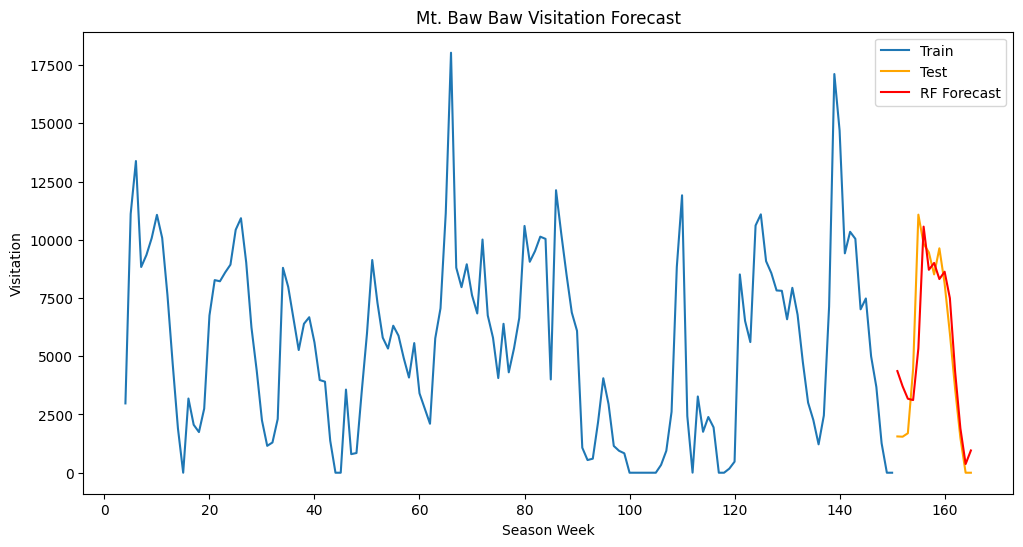

Mt. Stirling - MAE: 396.16, R^2: 0.53


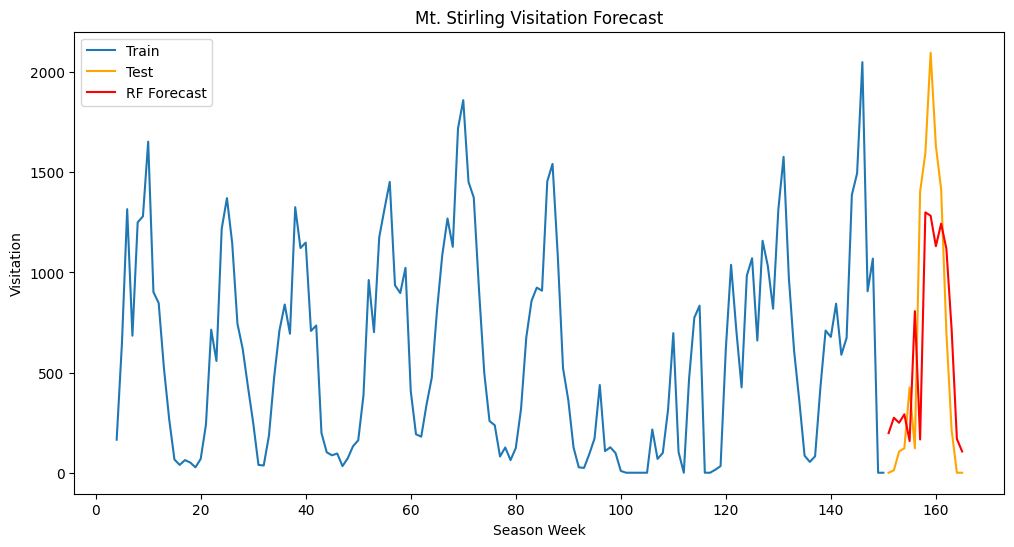

Mt. Hotham - MAE: 4201.46, R^2: 0.78


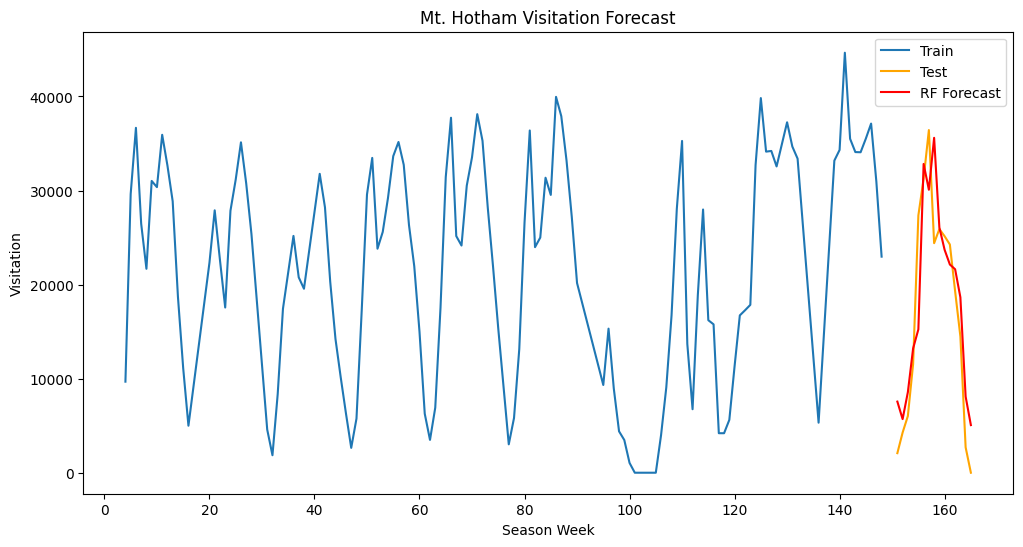

Falls Creek - MAE: 6430.25, R^2: 0.78


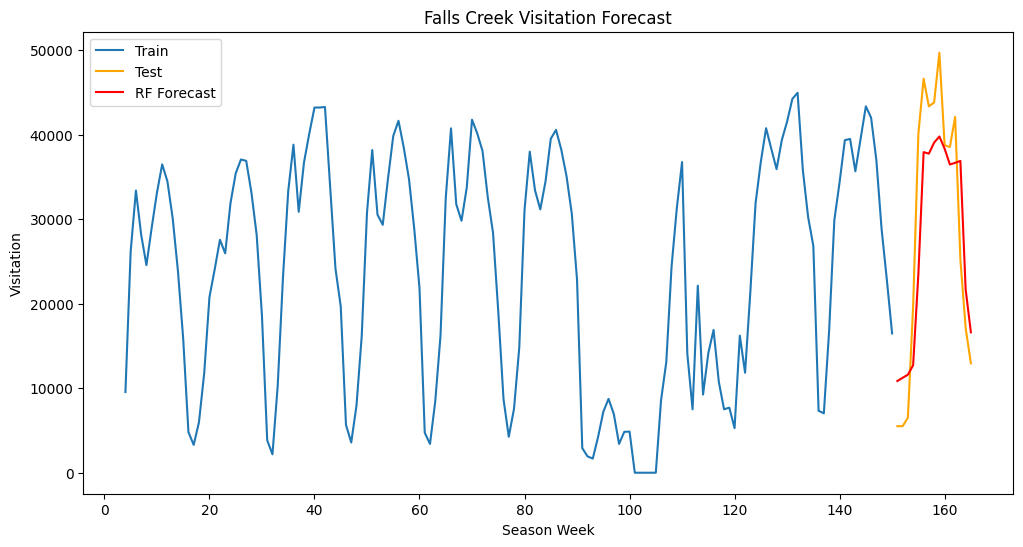

Mt. Buller - MAE: 7112.72, R^2: 0.82


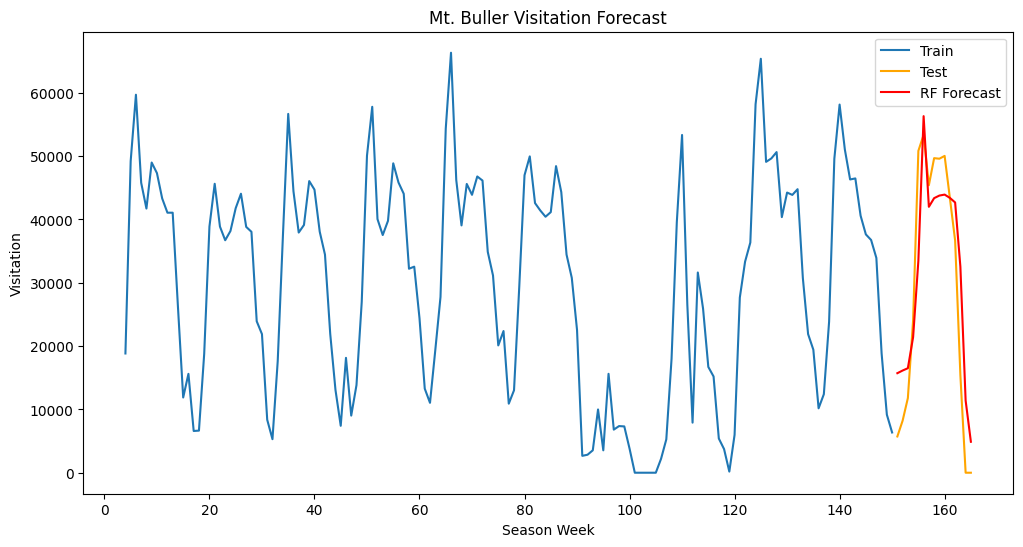

Selwyn - MAE: 950.09, R^2: 0.88


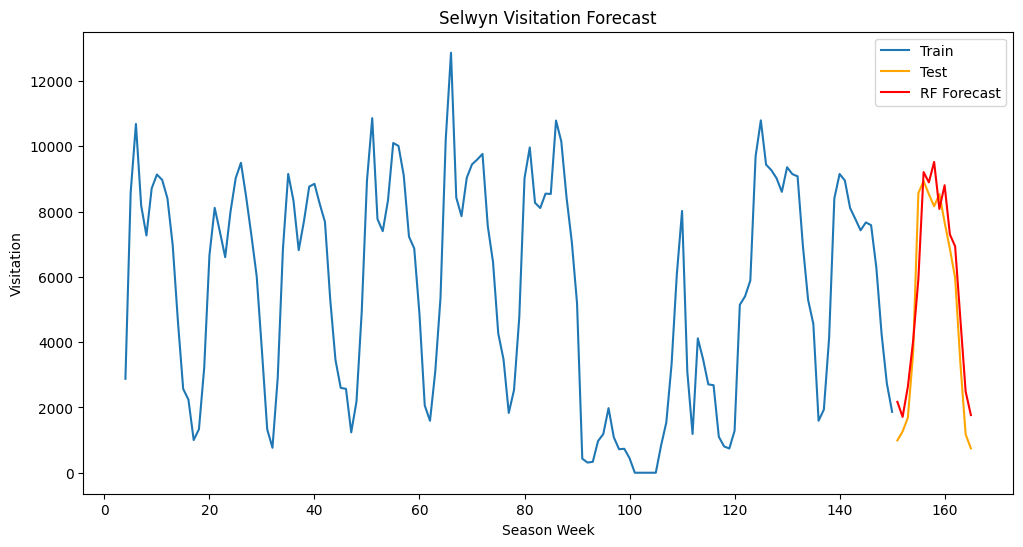

Thredbo - MAE: 5911.58, R^2: 0.81


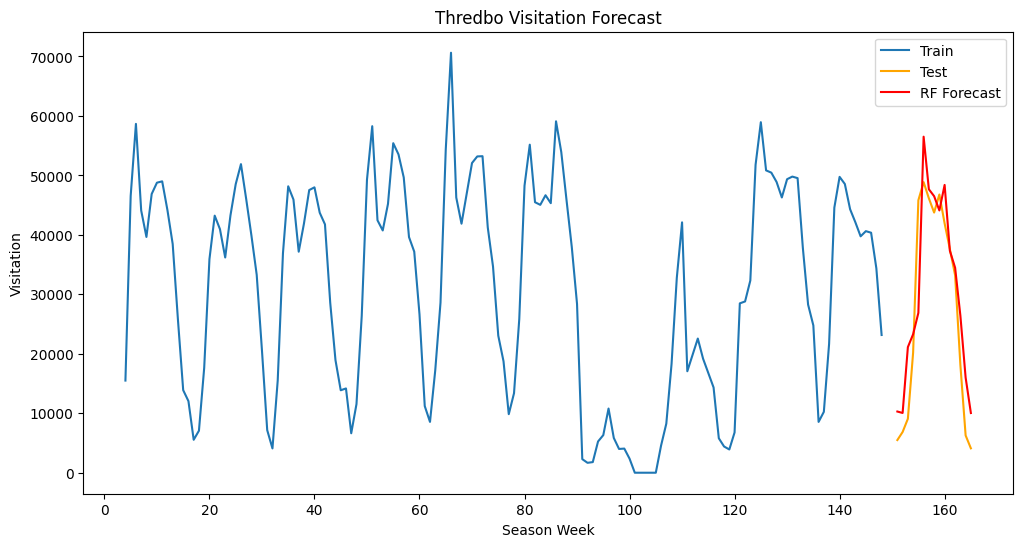

Perisher - MAE: 7785.33, R^2: 0.85


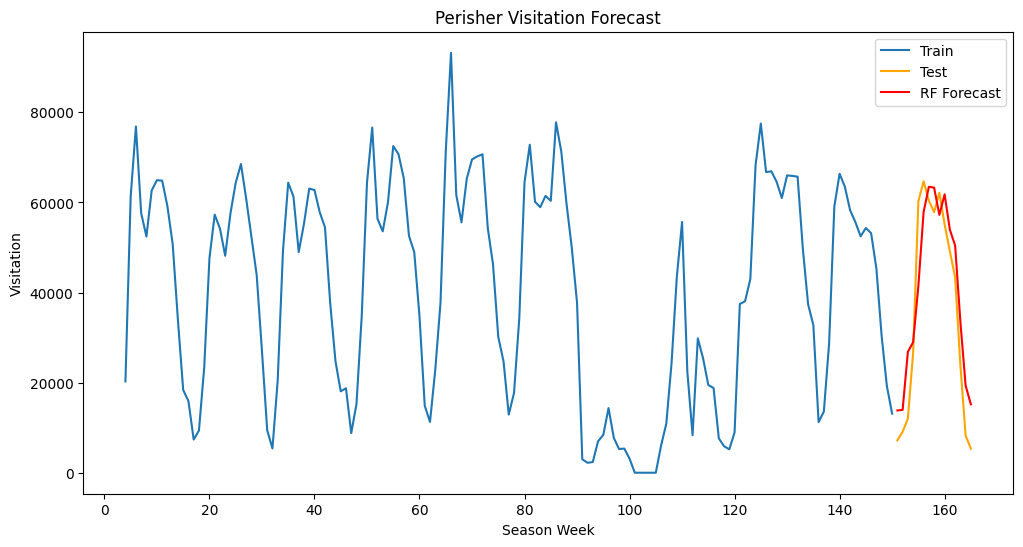

Charlotte Pass - MAE: 443.43, R^2: 0.82


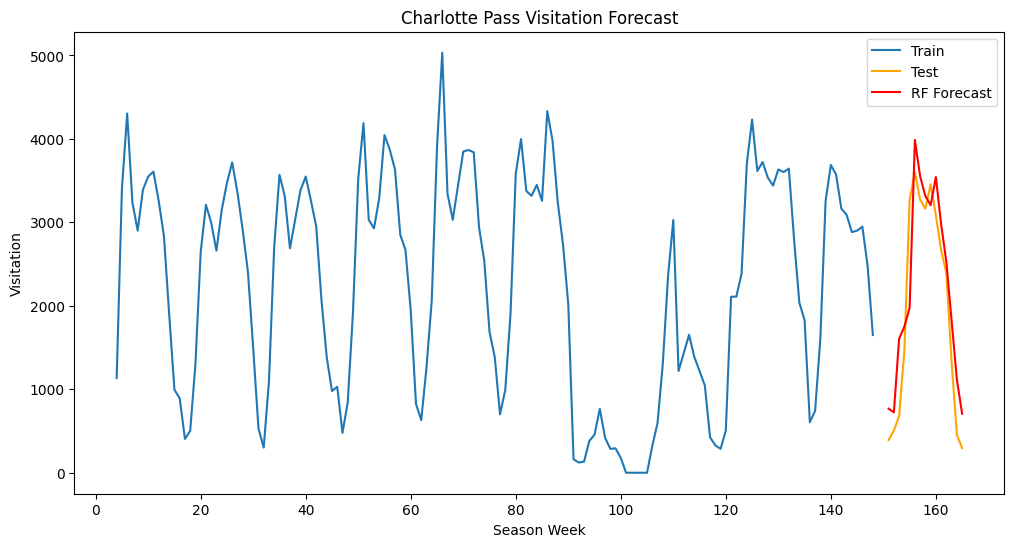

In [238]:
locations = {
    "Mt. Baw Baw": bawbaw,
    "Mt. Stirling": stirling,
    "Mt. Hotham": hotham,
    "Falls Creek": falls,
    "Mt. Buller": buller,
    "Selwyn": selwyn,
    "Thredbo": thredbo,
    "Perisher": perisher,
    "Charlotte Pass": charlotte
}

for name, data in locations.items():
    random_forest_forecast(data, name)

In [235]:
def random_forest_forecast_future(df, resort_name, lags=3, forecast_weeks=30):
    """
    Predicts future visitation for `forecast_weeks` into the future
    using only past visitation values (autoregressive).
    
    df: historical dataframe with columns 'Year', 'Week', 'visitation'
    """
    df = df.copy()
    df["season_week"] = ((df["Year"].astype(int) - 2014) * 15 + df["Week"]).astype(int)
    df = df.set_index("season_week")

    # Create lag features
    for lag in range(1, lags+1):
        df[f'visitation_lag_{lag}'] = df["visitation"].shift(lag)
    
    df_lagged = df.dropna()
    
    # Train RF on all available data
    feature_cols = [f'visitation_lag_{lag}' for lag in range(1, lags+1)]
    X_train = df_lagged[feature_cols]
    y_train = df_lagged["visitation"]
    
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    
    # Start recursive forecasting
    last_row = df.iloc[-1:].copy()
    future_preds = []
    
    for i in range(forecast_weeks):
        X_last = last_row[feature_cols].copy()
        
        # Predict next visitation
        y_next = rf.predict(X_last)[0]
        future_preds.append(y_next)
        
        # Shift lag features for next iteration
        for lag in range(lags, 1, -1):
            last_row[f'visitation_lag_{lag}'] = last_row[f'visitation_lag_{lag-1}']
        last_row['visitation_lag_1'] = y_next
        
        # Increment season_week
        last_row.index = [last_row.index[0] + 1]
    
    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df["visitation"], label="Historical")
    future_index = np.arange(df.index[-1]+1, df.index[-1]+1+forecast_weeks)
    plt.plot(future_index, future_preds, label="RF Forecast", color="red")
    plt.title(f"{resort_name} Visitation Forecast (No Weather)")
    plt.xlabel("Season Week")
    plt.ylabel("Visitation")
    plt.legend()
    plt.show()
    
    #return future_preds

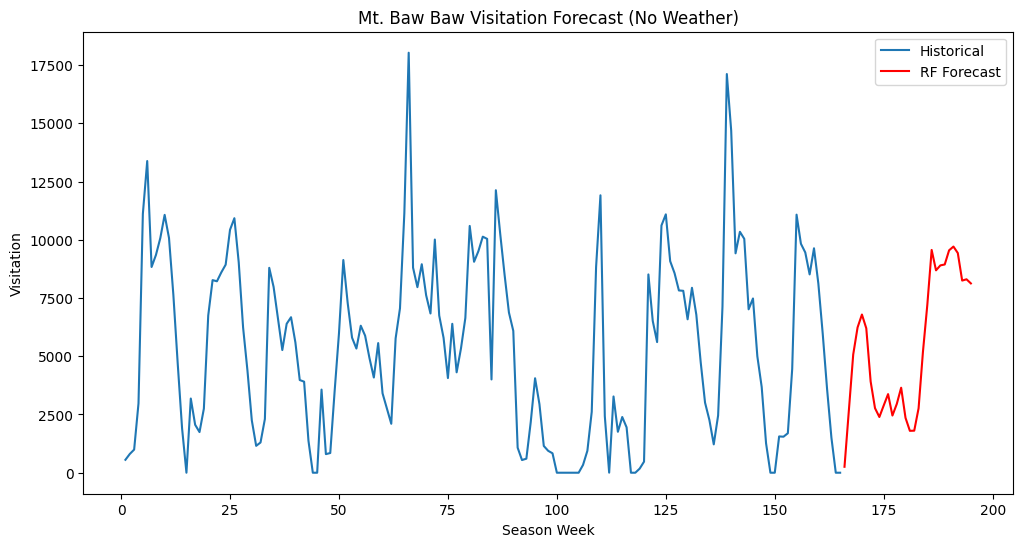

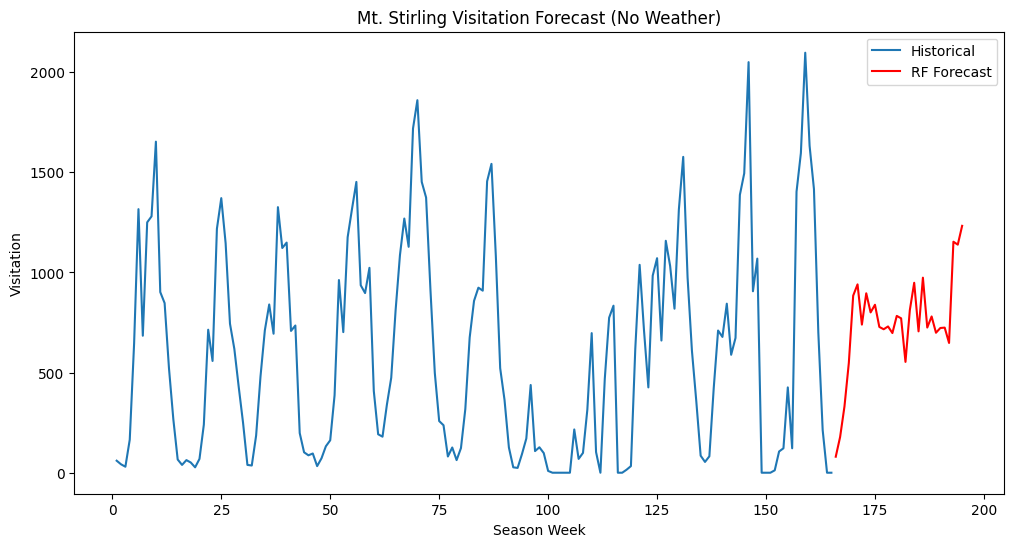

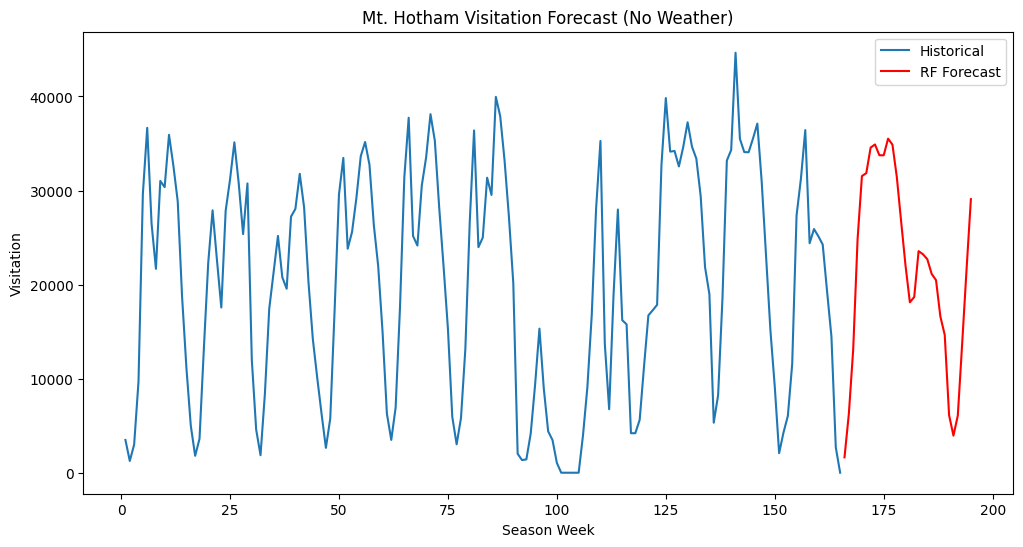

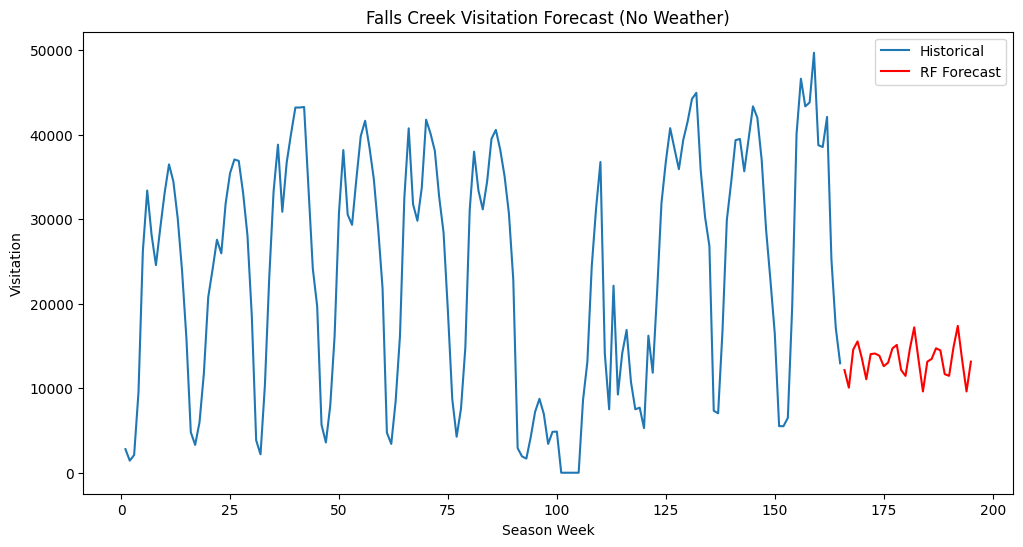

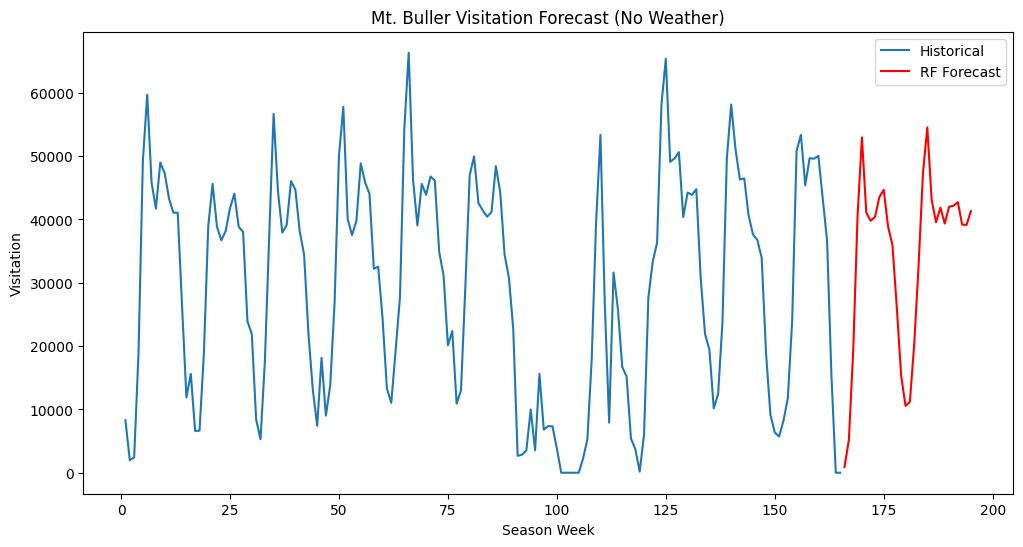

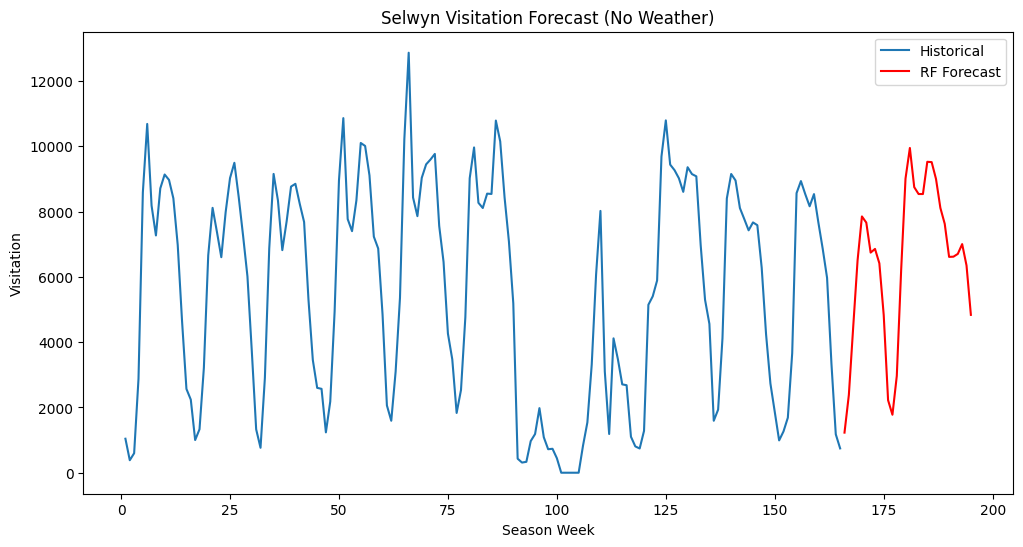

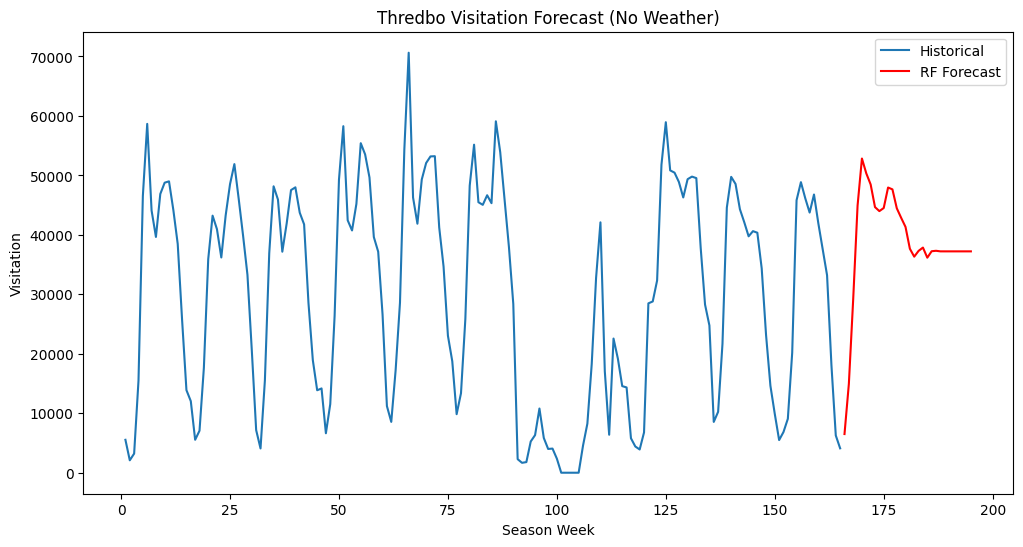

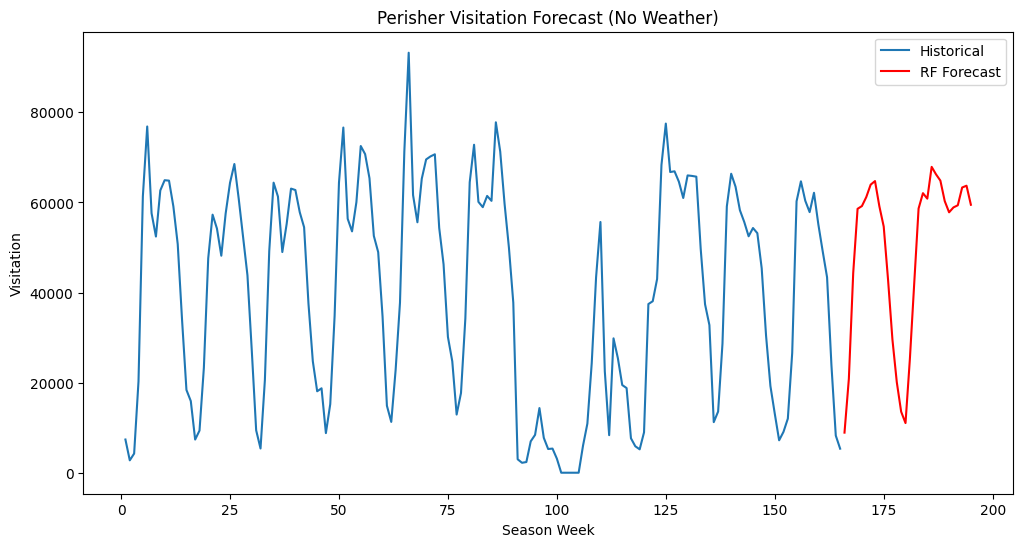

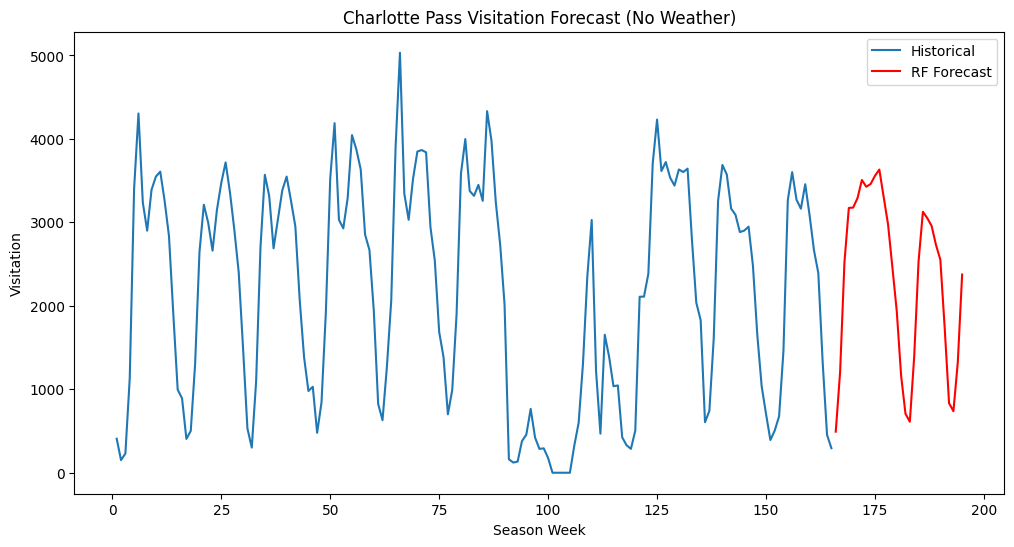

In [239]:
for name, data in locations.items():
    random_forest_forecast_future(data, name)

# Exponential Smoothing (FAIL)

In [152]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

In [136]:
perisher_data = perisher.iloc[:, :3]
perisher_data = peri

Year  Week  visitation
0    2014.0   1.0      7370.0
1    2014.0   2.0      2751.0
2    2014.0   3.0      4255.0
3    2014.0   4.0     20265.0
4    2014.0   5.0     61339.0
..      ...   ...         ...
160  2024.0  11.0     49136.0
161  2024.0  12.0     43382.0
162  2024.0  13.0     23908.0
163  2024.0  14.0      8244.0
164  2024.0  15.0      5336.0

[165 rows x 3 columns]

In [142]:
perisher_data["season_week"] = (perisher_data["Year"].astype(int) - 2014) * 15 + perisher_data["Week"]
perisher_data = perisher_data.set_index("season_week")

In [143]:
perisher_data

Year  Week  visitation
season_week                          
1.0          2014.0   1.0      7370.0
2.0          2014.0   2.0      2751.0
3.0          2014.0   3.0      4255.0
4.0          2014.0   4.0     20265.0
5.0          2014.0   5.0     61339.0
...             ...   ...         ...
161.0        2024.0  11.0     49136.0
162.0        2024.0  12.0     43382.0
163.0        2024.0  13.0     23908.0
164.0        2024.0  14.0      8244.0
165.0        2024.0  15.0      5336.0

[165 rows x 3 columns]

In [159]:
def holt_winters_forecast(df, location_name, seasonal_periods=15, test_weeks=15):
    """
    Apply Holt-Winters Exponential Smoothing to forecast ski visitation.
    
    Args:
        df (pd.DataFrame): Must contain columns ["Year", "Week", "visitation"].
        location_name (str): Name of the location (for labeling plots).
        seasonal_periods (int): Seasonality length (default=15 weeks).
        test_weeks (int): Number of weeks to hold out for testing (default=15).
        
    Returns:
        model, forecast, mae, r2
    """
    # Create continuous week index
    df = df.copy()
    df["season_week"] = (df["Year"].astype(int) - df["Year"].min()) * seasonal_periods + df["Week"]
    df = df.set_index("season_week")
    
    # Train/test split
    train = df.iloc[:-test_weeks]
    test = df.iloc[-test_weeks:]
    
    # Fit model
    model = ExponentialSmoothing(
        train["visitation"],
        trend="add",
        seasonal="add",
        seasonal_periods=seasonal_periods
    ).fit()
    
    # Forecast
    forecast = model.forecast(steps=test_weeks)
    
    # Metrics
    mae = mean_absolute_error(test["visitation"], forecast)
    r2 = r2_score(test["visitation"], forecast)
    
    print(f"📍 {location_name}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(train.index, train["visitation"], label="Train")
    plt.plot(test.index, test["visitation"], label="Test", color="orange")
    plt.plot(test.index, forecast, label="Forecast", color="red")
    plt.title(f"Holt-Winters Forecast for {location_name}")
    plt.legend()
    plt.show()
    
    

📍 Mt. Baw Baw
MAE: 2326.02
R²: 0.39


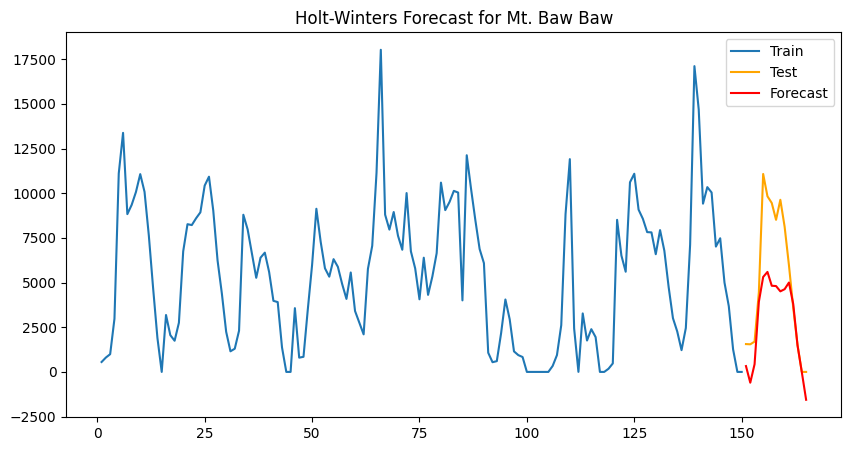

📍 Mt. Stirling
MAE: 371.06
R²: 0.46


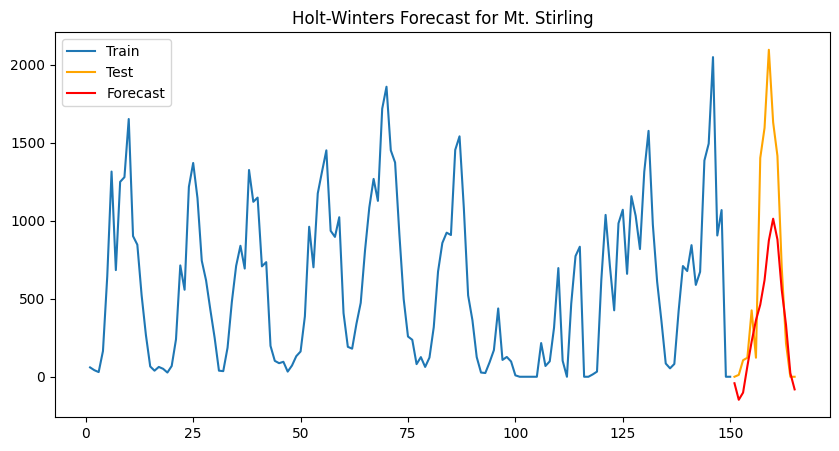

📍 Mt. Hotham
MAE: 5629.02
R²: 0.61


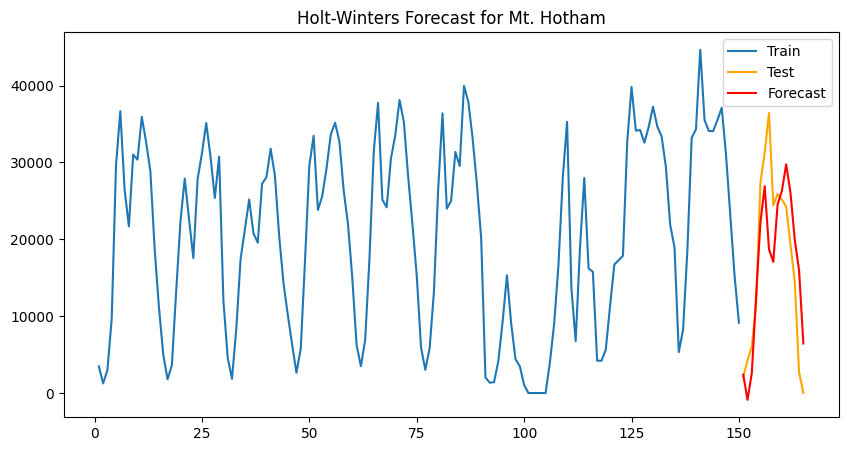

📍 Falls Creek
MAE: 8104.00
R²: 0.60


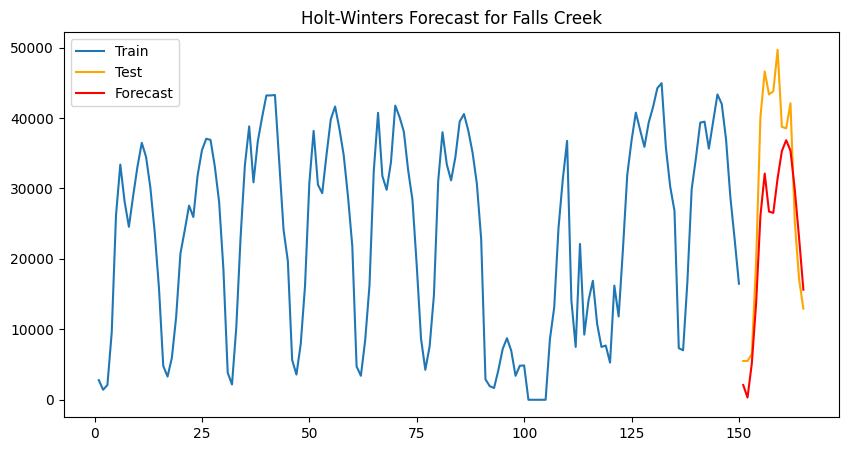

📍 Mt. Buller
MAE: 12052.84
R²: 0.54


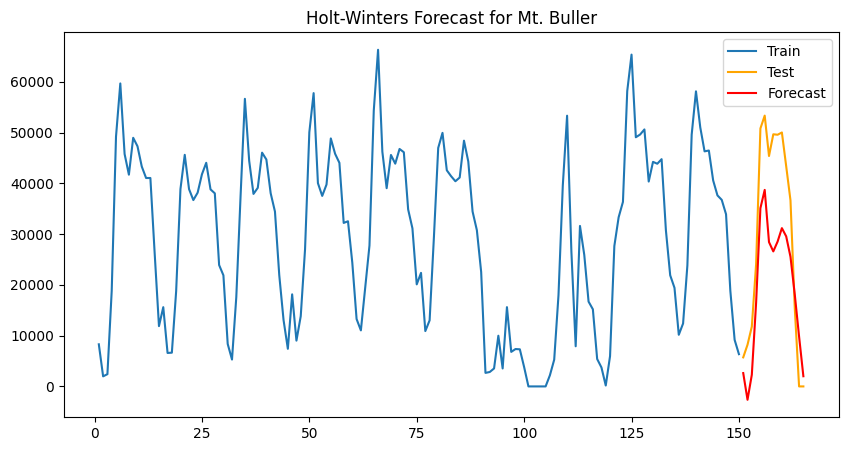

📍 Selwyn
MAE: 1242.81
R²: 0.78


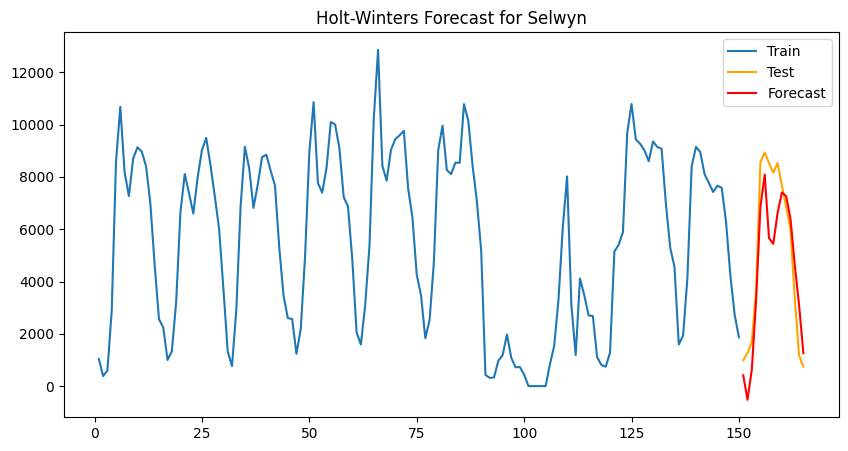

📍 Thredbo
MAE: 6870.58
R²: 0.77


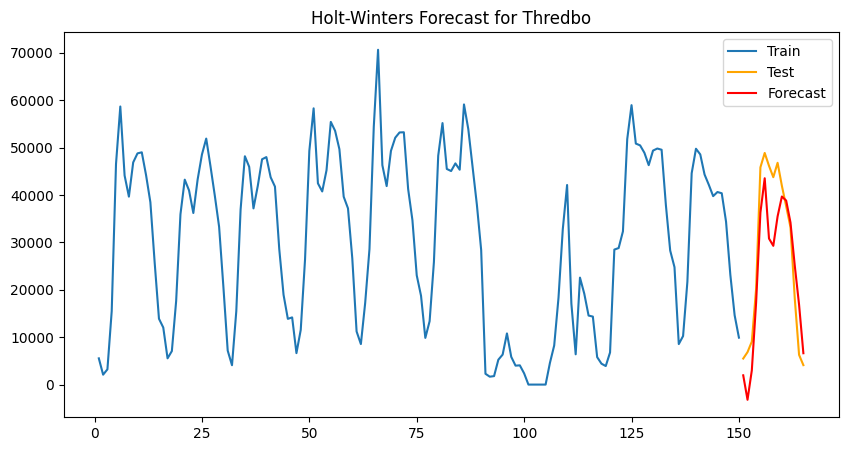

📍 Perisher
MAE: 8960.95
R²: 0.78


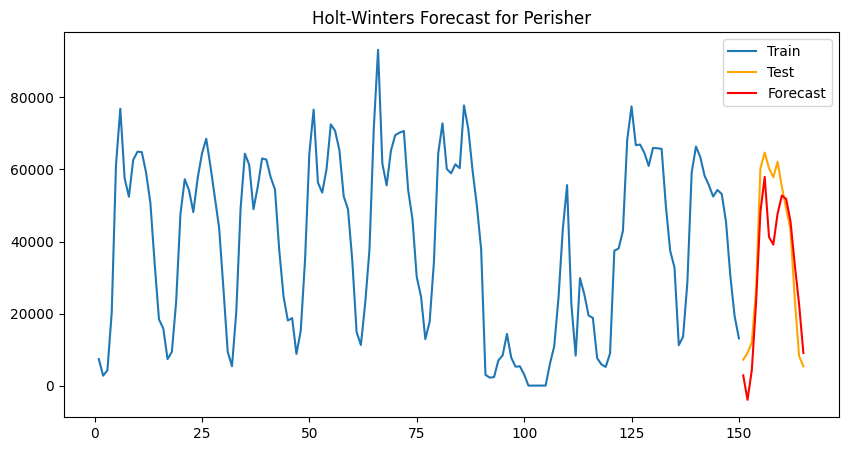

📍 Charlotte Pass
MAE: 562.27
R²: 0.74


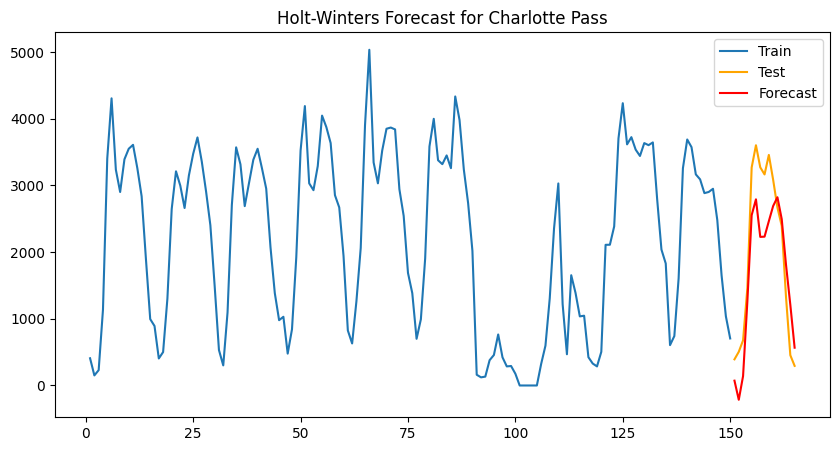

In [171]:
locations = {
    "Mt. Baw Baw": bawbaw,
    "Mt. Stirling": stirling,
    "Mt. Hotham": hotham,
    "Falls Creek": falls,
    "Mt. Buller": buller,
    "Selwyn": selwyn,
    "Thredbo": thredbo,
    "Perisher": perisher,
    "Charlotte Pass": charlotte
}

# Loop through all locations
for name, data in locations.items():
    holt_winters_forecast(data, name)

In [176]:
def holt_winters_forecast_future(df, location_name, steps=30):
    # Prepare data
    #df = df[df["Year"] != 2020].copy()
    df = df.iloc[:, :3].copy()
    df["season_week"] = ((df["Year"].astype(int) - 2014) * 15 + df["Week"]).astype(int)
    df = df.set_index("season_week")
    
    # Fit Holt-Winters on all data
    model = ExponentialSmoothing(
        df["visitation"],
        trend="add",
        seasonal="add",
        seasonal_periods=15
    ).fit()
    
    # Forecast next 'steps' periods
    forecast = model.forecast(steps=steps)
    
    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df["visitation"], label="Historical")
    plt.plot(range(df.index[-1]+1, df.index[-1]+1+steps), forecast, label="Forecast", color="red")
    plt.title(f"Holt-Winters Forecast for {location_name}")
    plt.xlabel("Season Week")
    plt.ylabel("Visitation")
    plt.legend()
    plt.show()
    
    return forecast

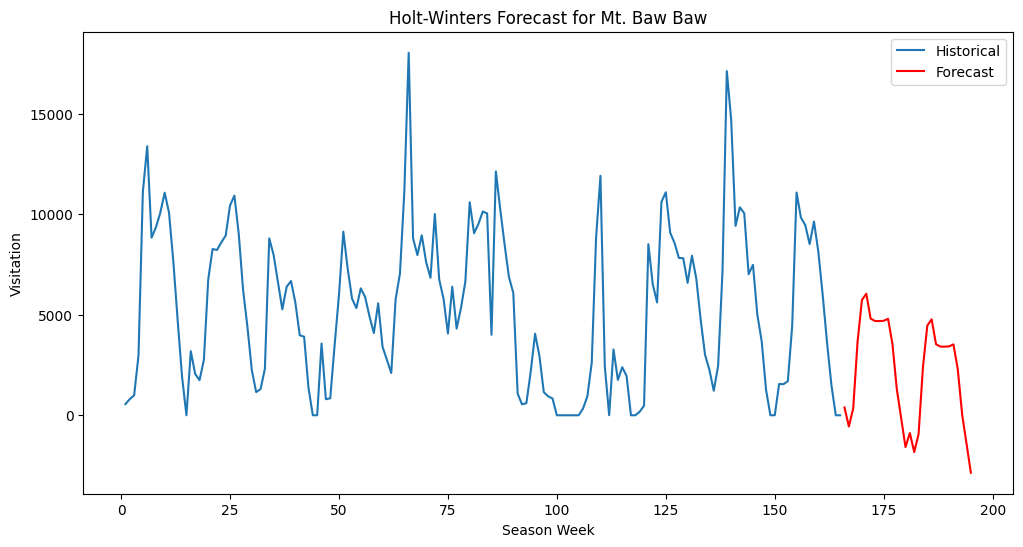

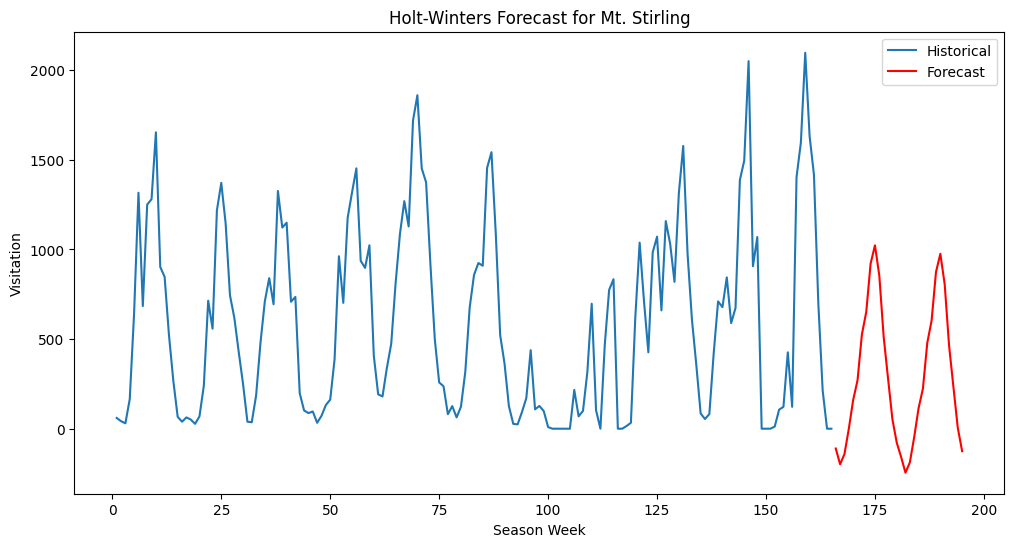

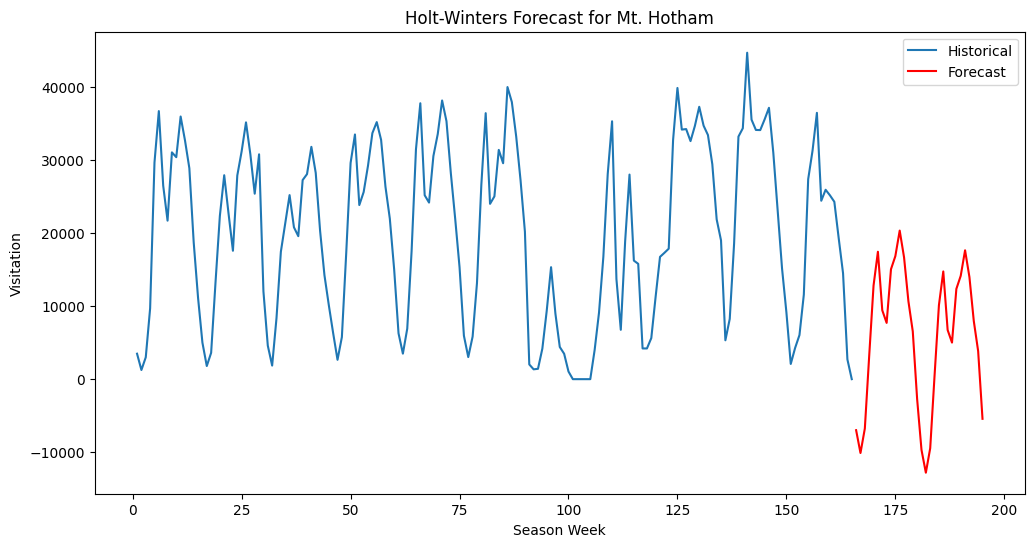

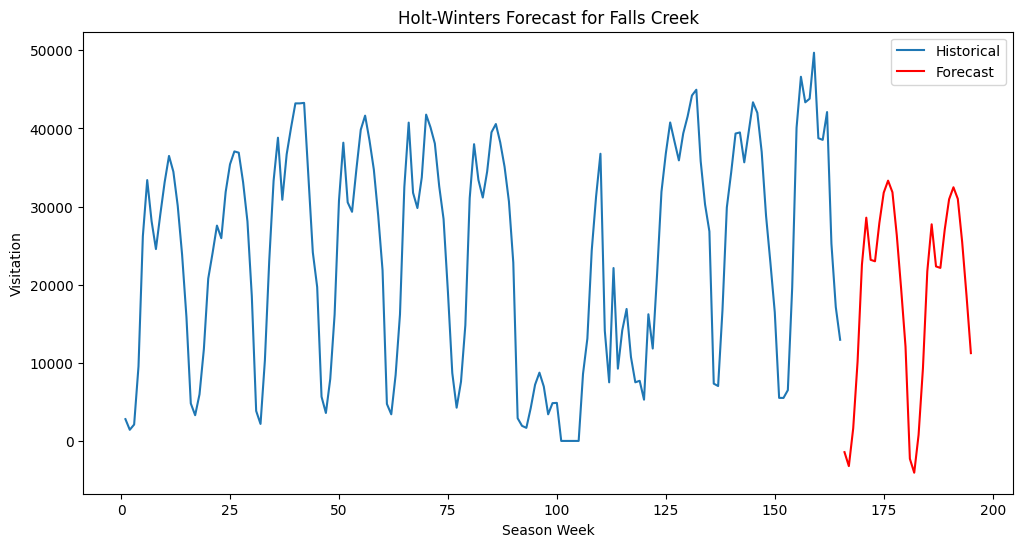

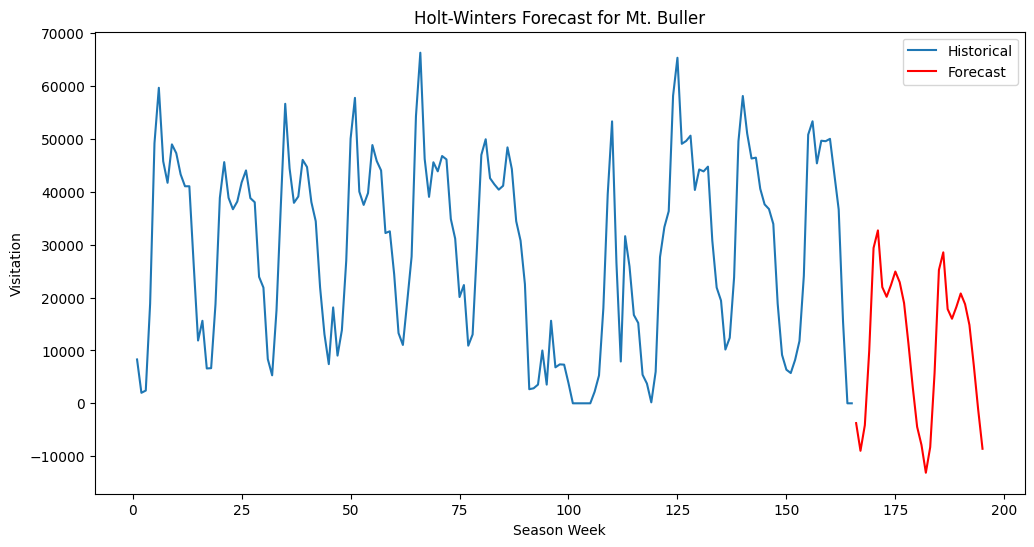

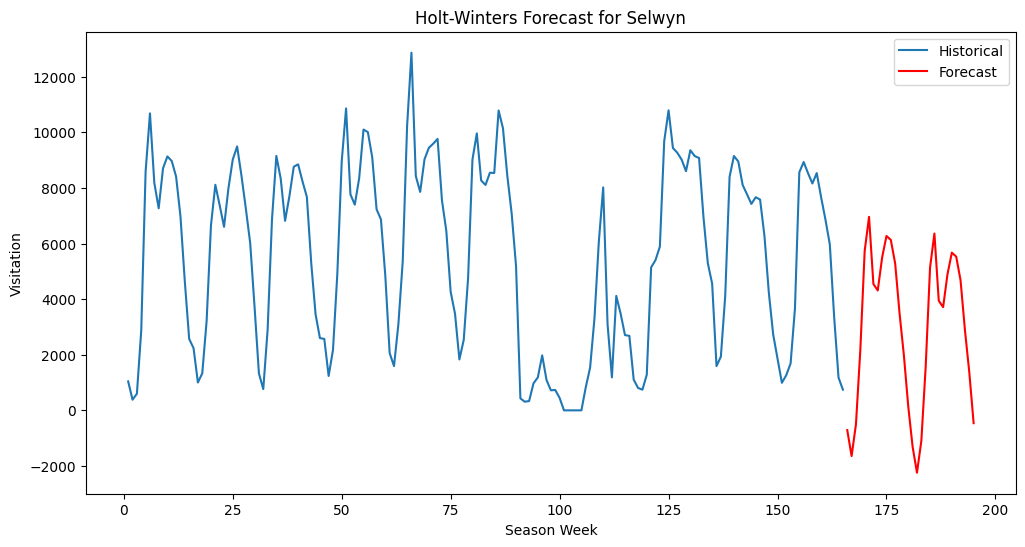

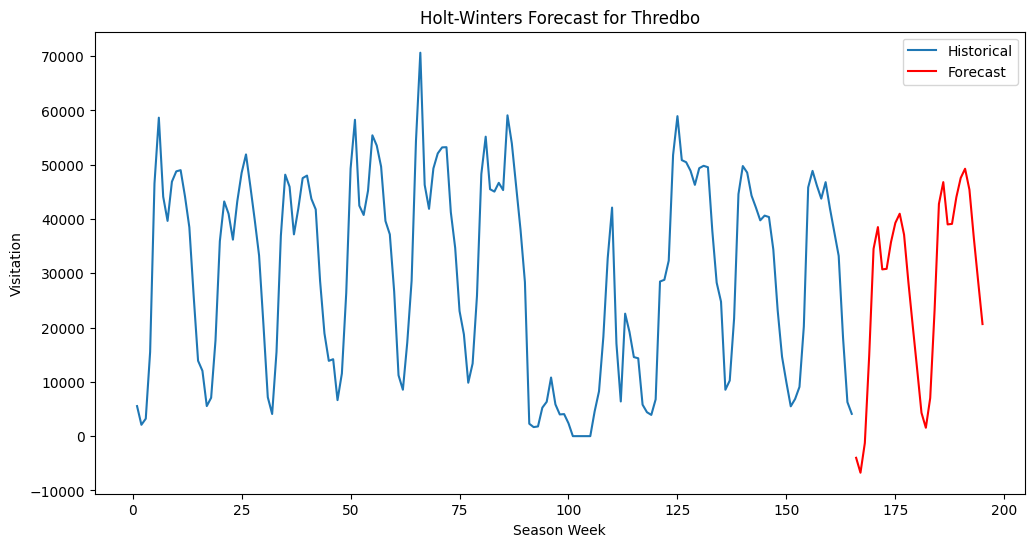

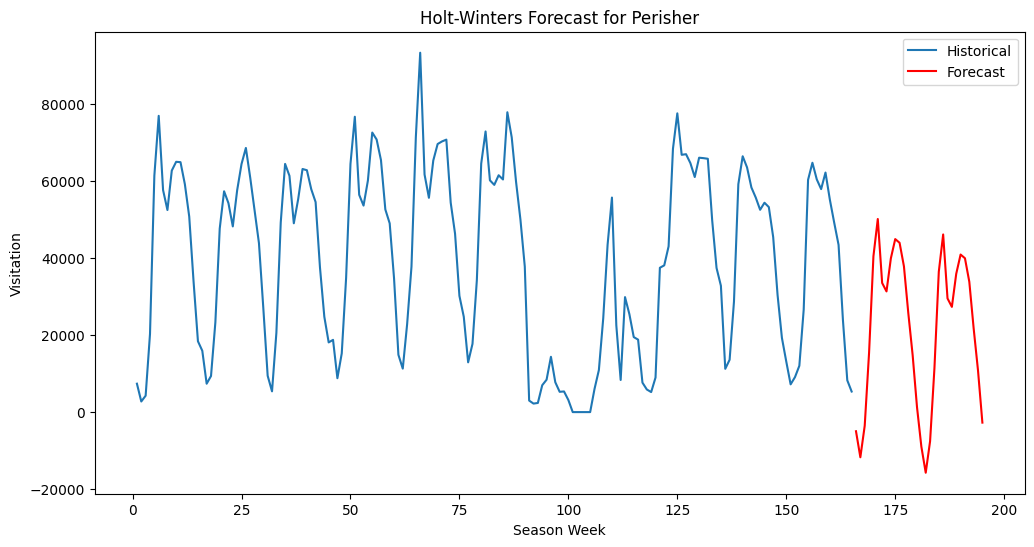

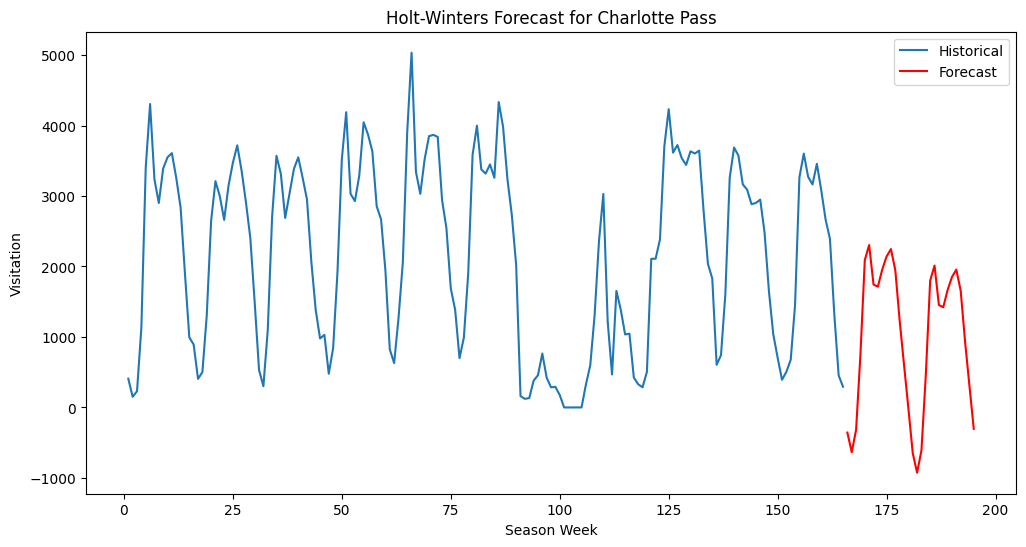

In [177]:
for name, data in locations.items():
    holt_winters_forecast_future(data, name, steps=30)

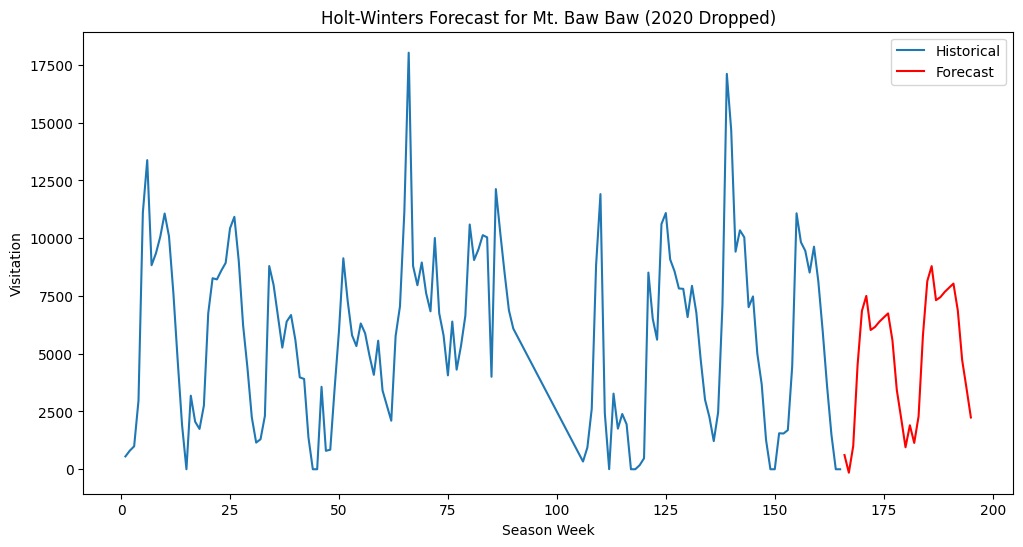

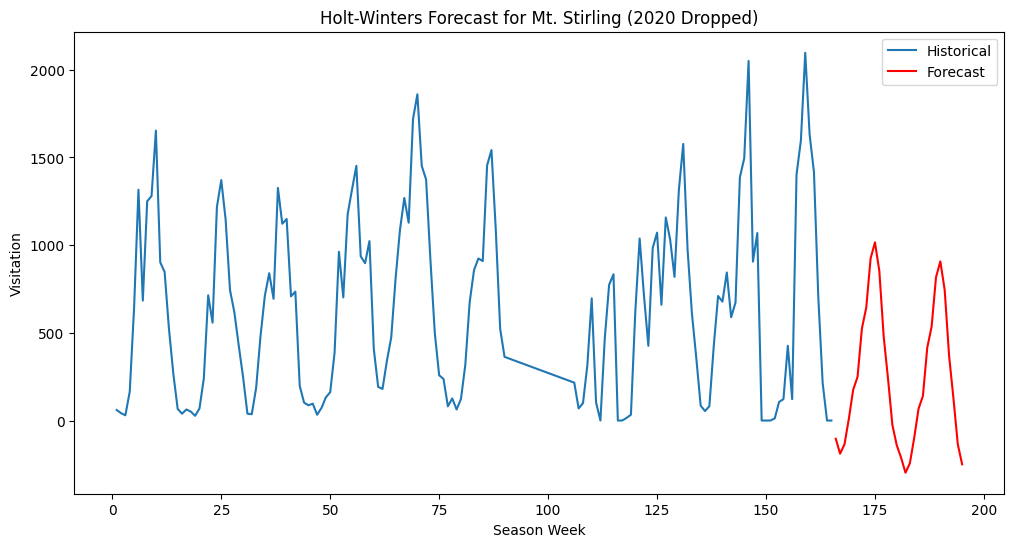

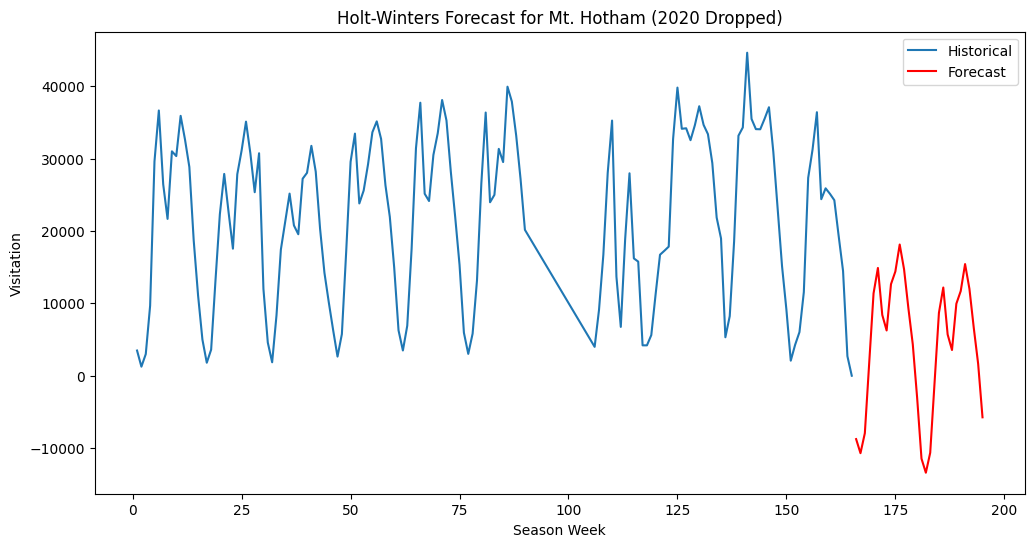

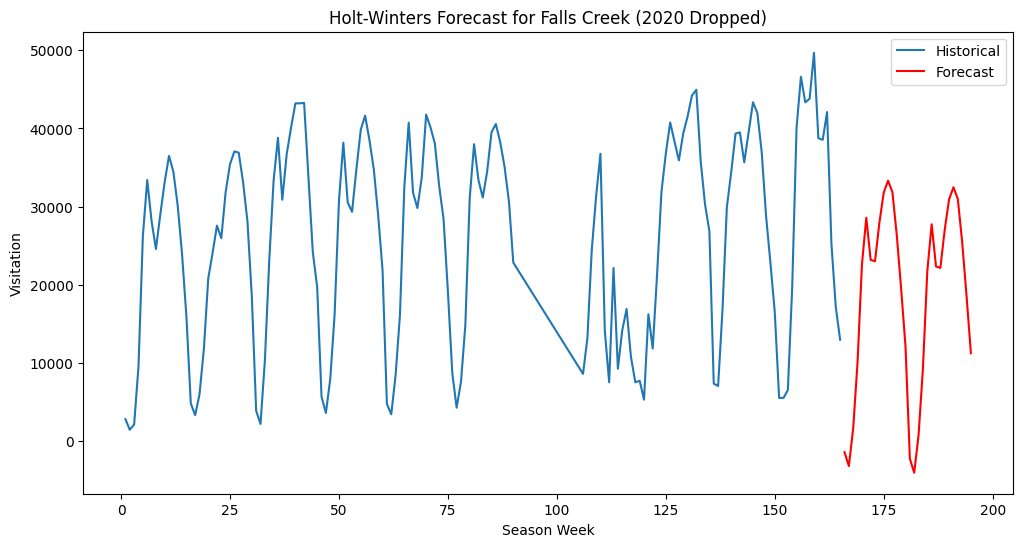

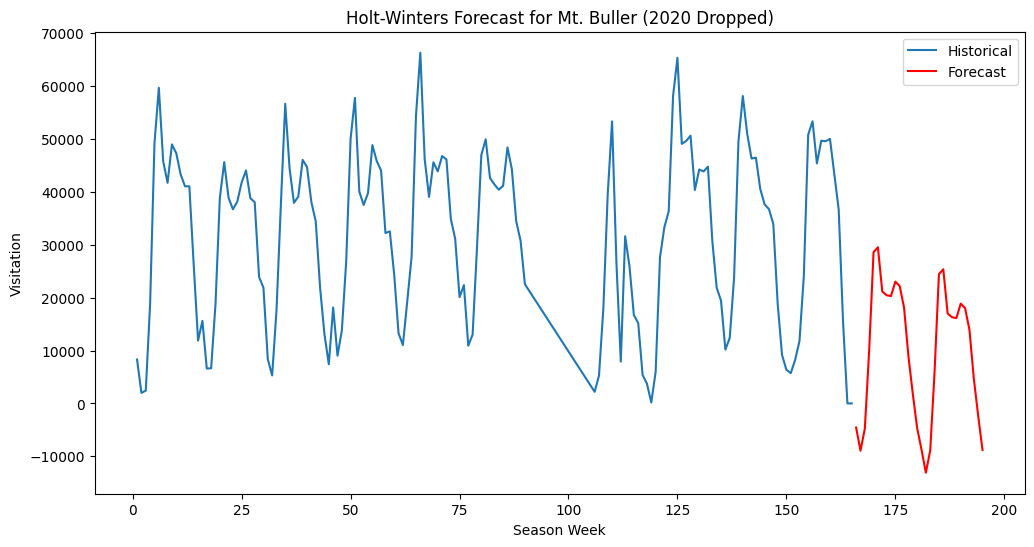

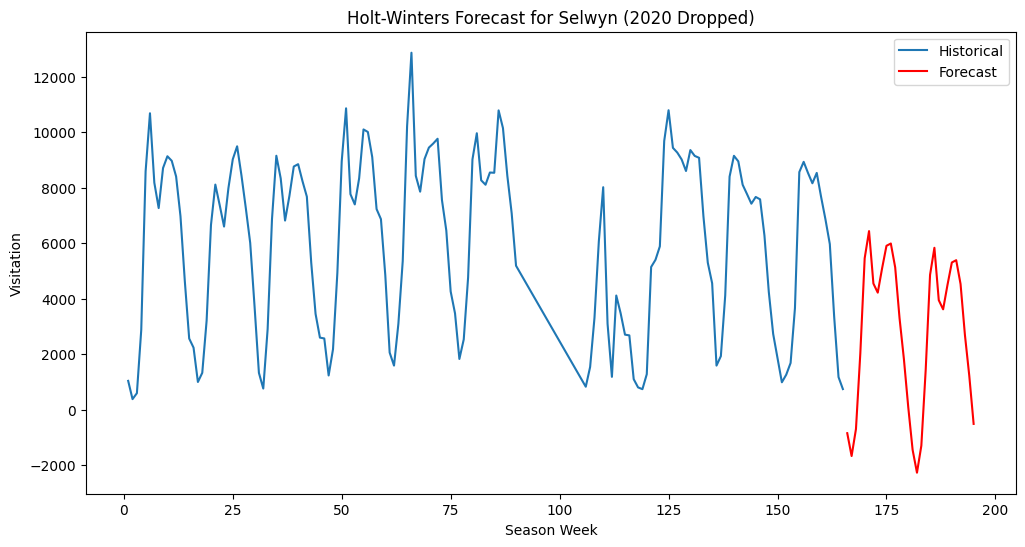

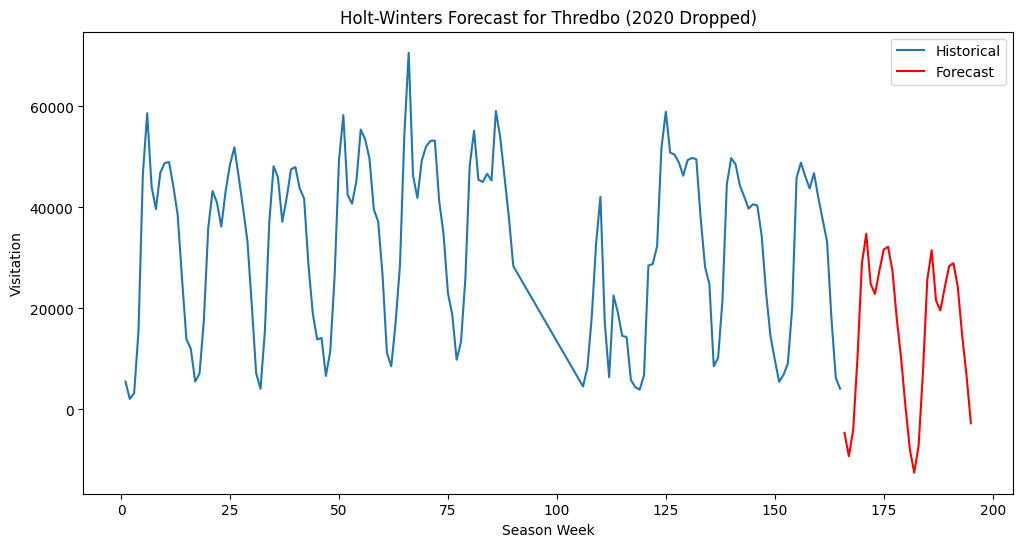

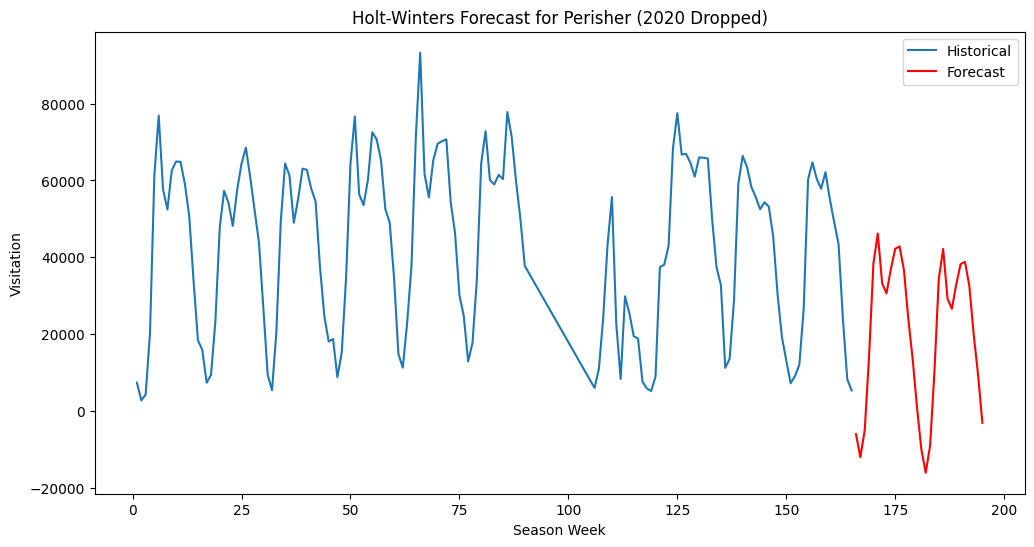

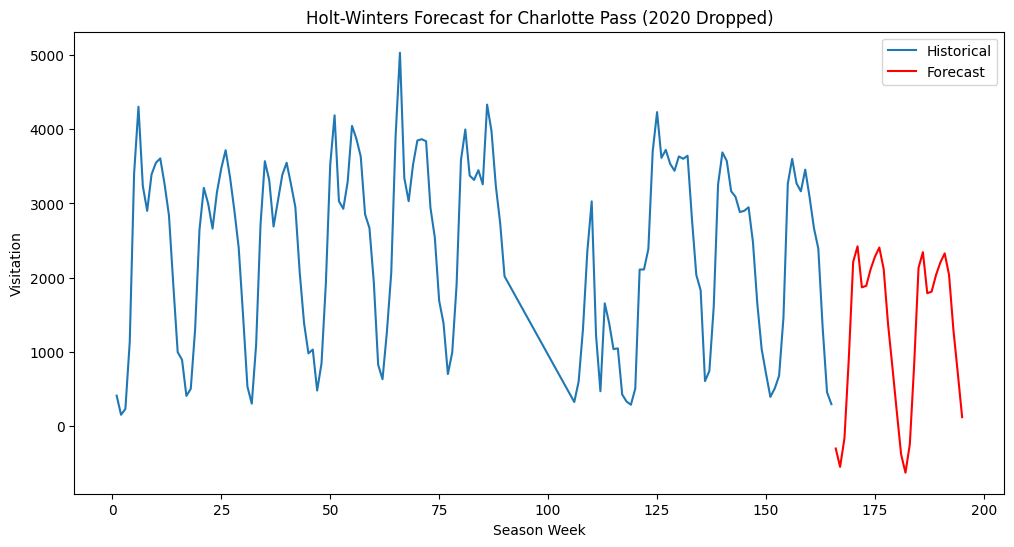

In [182]:
for name, data in locations.items():
    holt_winters_forecast_future2(data, name, steps=30)

In [181]:
def holt_winters_forecast_future2(df, location_name, steps=30):
    # Prepare data
    df = df[df["Year"] != 2020].copy()
    #df = df.iloc[:, :3].copy()
    df["season_week"] = ((df["Year"].astype(int) - 2014) * 15 + df["Week"]).astype(int)
    df = df.set_index("season_week")
    
    # Fit Holt-Winters on all data
    model = ExponentialSmoothing(
        df["visitation"],
        trend="add",
        seasonal="add",
        seasonal_periods=15
    ).fit()
    
    # Forecast next 'steps' periods
    forecast = model.forecast(steps=steps)
    
    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df["visitation"], label="Historical")
    plt.plot(range(df.index[-1]+1, df.index[-1]+1+steps), forecast, label="Forecast", color="red")
    plt.title(f"Holt-Winters Forecast for {location_name} (2020 Dropped)")
    plt.xlabel("Season Week")
    plt.ylabel("Visitation")
    plt.legend()
    plt.show()
    
    return forecast